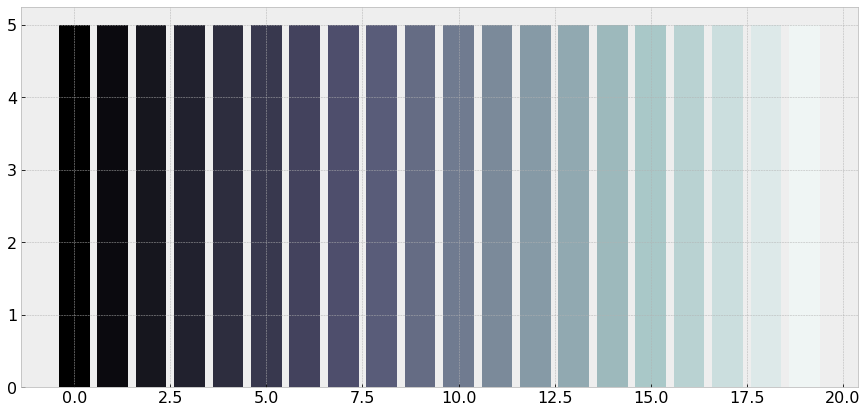

In [77]:
k = 20
for i in range(k):
    color = cm.nipy_spectral(float(i)/k)
    color = cm.get_cmap('bone')(i/k)
    plt.bar(i, 5, color = color)

# Import

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import re
import seaborn as sns
import umap.umap_ as umap

from math import ceil
from matplotlib import cm
from plotly import express as px
from scipy.cluster import hierarchy as hc
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder

## Funções de suporte

In [2]:
def jupyter_settings():
    %matplotlib inline
    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = [15, 7]
    plt.rcParams['font.size'] = 16
    
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
jupyter_settings()

In [3]:
def data_summary(num_attributes):
    # Central tendency - mean, median
    tc1 = pd.DataFrame(num_attributes.apply(np.mean)).T
    tc2 = pd.DataFrame(num_attributes.apply(np.median)).T
    
    # Variability - std, coefficient of variation, min, max, range, skew, kurtosis
    d1 = pd.DataFrame(num_attributes.apply(min)).T
    d2 = pd.DataFrame(num_attributes.apply(max)).T
    d3 = pd.DataFrame(num_attributes.apply(lambda x: x.max()-x.min())).T
    d4 = pd.DataFrame(num_attributes.apply(np.std)).T
    d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
    d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T
    d7 = d4/tc1# cv
    
    # Concatenate
    s = pd.concat([d1, d2, d3, tc1, tc2, d4, d7, d5, d6]).T.reset_index()
    s.columns = ['columns', 'min', 'max', 'range', 'mean', 'median', 'std', 'cv', 'skew', 'kurtosis']

    return s

In [5]:
def silhouette_plot(X, labels, ax):
    silhouette_avg = silhouette_score(X, labels)
    
    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, labels)
    
    y_lower = 10
    k = np.unique(labels).shape[0]
    for j in range(k):
        # Aggregate the silhouette scores for samples belonging to
        # cluster j, and sort them
        jth_cluster_silhouette_values = sample_silhouette_values[labels == j]
        jth_cluster_silhouette_values.sort()
        
        size_cluster_j = jth_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_j
        
        color = cm.nipy_spectral(float(j) / k)
        ax.fill_betweenx(np.arange(y_lower, y_upper),
                          0,
                          jth_cluster_silhouette_values,
                          facecolor=color,
                          edgecolor=color,
                          alpha=0.7)
        
        # Label the silhouette plots with their cluster numbers at the middle
        ax.text(-0.05, y_lower + 0.5 * size_cluster_j, str(j))
        
        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples
    
    ax.set_xlabel("The silhouette coefficient values")
    ax.set_ylabel("Cluster label")
    ax.set_title(
        'Silhouette score for {} clusters: {:.2f}'.format(k, silhouette_avg),
        fontsize = 12
    )

    # The vertical line for average silhouette score of all the values
    ax.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax.set_yticks([]) # Clear the yaxis labels / ticks
    ax.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

## Importar dados

In [5]:
df_raw = pd.read_csv('../data/raw/Ecommerce.csv', encoding = 'latin1')
df_raw.drop('Unnamed: 8', axis = 1, inplace = True)

# 1 Descrição dos dados

In [6]:
df1 = df_raw.copy()

## 1.1 Renomear colunas

In [7]:
cols = ['invoice', 'stock_code', 'description', 'quantity', 'invoice_date', 'unit_price', 'customer_id', 'country']
df1.columns = cols

In [8]:
df1.columns

Index(['invoice', 'stock_code', 'description', 'quantity', 'invoice_date',
       'unit_price', 'customer_id', 'country'],
      dtype='object')

**invoice:** Invoice number (A 6-digit integral number uniquely assigned to each transaction)

**stock_code:** Product (item) code

**description:** Product (item) name

**quantity:** The quantities of each product (item) per transaction

**invoice_date:** The day when each transaction was generated

**unit_price:** Unit price (Product price per unit)

**customer_id:** Customer number (Unique ID assigned to each customer)

**country:** Country name (The name of the country where each customer resides)

## 1.2 Dimensão dos dados

In [9]:
print('Número de linhas: {}'.format(df1.shape[0]))
print('Número de colunas: {}'.format(df1.shape[1]))

Número de linhas: 541909
Número de colunas: 8


## 1.3 Tratar os NAs

In [10]:
df1['description'].fillna('-', inplace = True)

In [11]:
# Criando id únicos para cada fatura não identificada
df_missing = df1[df1['customer_id'].isna()]
df_not_missing = df1[~df1['customer_id'].isna()]

# Criar referência com base no número do invoice
df_ref = pd.DataFrame(df_missing['invoice'].drop_duplicates())
df_ref['customer_id'] = np.arange(19000, 19000+len(df_ref), 1)

# Juntar referência com dataframe original
df1 = df1.merge(df_ref, how = 'left', on = 'invoice')

# Coalesce
df1['customer_id'] = df1['customer_id_x'].combine_first(df1['customer_id_y'])

# Drop extra id columns
df1.drop(columns = ['customer_id_x', 'customer_id_y'], inplace = True)

In [12]:
df1.isna().sum()

invoice         0
stock_code      0
description     0
quantity        0
invoice_date    0
unit_price      0
country         0
customer_id     0
dtype: int64

## 1.4 Tipo dos dados

In [13]:
df1['invoice_date'] = pd.to_datetime(df1['invoice_date'], format = '%d-%b-%y')
df1['customer_id'] = df1['customer_id'].astype(int)

In [14]:
df1.dtypes

invoice                 object
stock_code              object
description             object
quantity                 int64
invoice_date    datetime64[ns]
unit_price             float64
country                 object
customer_id              int32
dtype: object

## 1.5 Estatística descritiva

In [15]:
num_attributes = df1[['quantity', 'unit_price']]
cat_attributes = df1[['invoice', 'stock_code', 'description', 'customer_id', 'country']]

### 1.5.1 Atributos numéricos

In [16]:
data_summary(num_attributes)

columns       min      max      range      mean  median         std  \
0    quantity -80995.00  80995.0  161990.00  9.552250    3.00  218.080957   
1  unit_price -11062.06  38970.0   50032.06  4.611114    2.08   96.759764   

         skew       kurtosis  
0   -0.264076  119769.160031  
1  186.506972   59005.719097

### 1.5.2 Atributos categóricos

In [17]:
cat_attributes.apply(lambda x: x.nunique())

invoice        25900
stock_code      4070
description     4224
customer_id     8082
country           38
dtype: int64

In [18]:
df1[df1['stock_code'].apply(
    lambda x: bool(re.search('^[a-zA-Z]+$', x)))
   ]['stock_code'].unique()

array(['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY',
       'DCGSSGIRL', 'PADS', 'B', 'CRUK'], dtype=object)

# 2 Filtragem das variáveis

## Data checkpoint

In [19]:
df2 = df1.copy()

In [20]:
df2.to_csv('../data/interim/c3_df2.csv', index = False)

In [40]:
df2 = pd.read_csv('../data/interim/c3_df2.csv')
df2['invoice_date'] = pd.to_datetime(df2['invoice_date'])

## 2.1 Stock code

In [41]:
size_of_data = len(df2)

In [42]:
df2.loc[df2['stock_code'].apply(lambda x: x.isalpha()), 'stock_code'].unique()

array(['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY',
       'DCGSSGIRL', 'PADS', 'B', 'CRUK'], dtype=object)

In [43]:
# Remover stock code M, POST, PADS, DOT, CRUK
bad_code = ['M', 'POST', 'PADS', 'DOT', 'CRUK']
bad_code = ['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY', 'DCGSSGIRL', 'PADS', 'B', 'CRUK']
df2 = df2[~df2['stock_code'].isin(bad_code)]

## 2.2 Quantity & price

In [44]:
# Remover quantidades negativas dos clientes não identificados
df2 = df2.drop(df2[(df2['quantity'] < 0) & (df2['customer_id'] >= 19000)].index)

In [45]:
# Remover itens com preço zero
df2 = df2[df2['unit_price'] > 0]

## 2.3 Description

In [46]:
df2.loc[df2['description'].apply(lambda x: x.isalpha()), 'description'].unique()

array(['CARRIAGE'], dtype=object)

In [47]:
# Remover description CARRIAGE
df2 = df2[df2['description'] != 'CARRIAGE']

## 2.4 Customer id

In [48]:
# Clientes cujos id só possuem mais registros de devolução do que compra.
bad_customers = [12605, 12666, 12870, 12943, 13693, 
                 13829, 13958, 14119, 14213, 14627, 
                 14679, 14777, 15638, 15728, 16061, 
                 16138, 16252, 16262, 16428, 16579, 
                 16742, 16995, 17307, 17547, 17820, 
                 18141, 18256, 15823, 17548, 16546, 12346, 16446]
df2 = df2[~df2['customer_id'].isin(bad_customers)]

## 2.5 Dados filtrados

In [49]:
print('Dados removidos: {:.1f}%'.format(100*(1-df2.shape[0]/size_of_data)))
print('Número de linhas: {}'.format(df2.shape[0]))

Dados removidos: 1.1%
Número de linhas: 536162


# 3 Feature engineering

## Data checkpoint

In [50]:
df3 = df2.copy()

In [51]:
df3.to_csv('../data/interim/c3_df3.csv', index = False)

In [10]:
df3 = pd.read_csv('../data/interim/c3_df3.csv')
df3['invoice_date'] = pd.to_datetime(df3['invoice_date'])

## 3.1 Criação das variáveis

*Customer*

**customer_id:** customer identification

**country:** customer's country of residence

**vintage:** how many months customer is client

*Revenue*

**revenue:** total amount spend by customer so far

**return:** total value of charge back invoices

**avg_ticket:** average expense of a customer per invoice

**low_purch:** lowest purchase value

**high_purch:** highest purchase value

**monthly_revenue:** monthly expense of a customer

*Frequency*

**invoices:** number of purchases

**monthly_invoices:** number of purchases (invoices) per month

**invoices_return:** number of returns

*Recency*

**recency:** time since last purchase

**mean_recency:** average interval between purchases

*Habits*

**mean_basket_size:** average number of items per purchase

**product_variety:** number of unique products

**low_unit_price:** smallest price of a single product purchased

**high_unit_price:** highest price of a single product purchased

**avg_unit_price:** average price of the products purchased

In [52]:
purchases = df3[~df3['invoice'].str.startswith('C')]
charge_back = df3[df3['invoice'].str.startswith('C')]

In [53]:
# Revenue
purchases['price'] = purchases['quantity']*purchases['unit_price']
charge_back['price'] = charge_back['quantity']*charge_back['unit_price']
df_customer = purchases[['customer_id', 'price']].groupby('customer_id').sum().reset_index().rename(columns = {'price': 'revenue'})

# Return
aux = charge_back[['customer_id', 'price']].groupby('customer_id').sum().reset_index().rename(columns = {'price': 'return'})
df_customer = df_customer.merge(aux, how = 'left', on = 'customer_id')
df_customer['return'].fillna(0, inplace = True)

# Invoices - number of purchases
aux = purchases[['customer_id', 'invoice']].groupby('customer_id').nunique().reset_index().rename(columns = {'invoice': 'invoices'})
df_customer = df_customer.merge(aux, how = 'left', on = 'customer_id')

# Invoices return
aux = charge_back[['customer_id', 'invoice']].groupby('customer_id').nunique().reset_index().rename(columns = {'invoice': 'invoices_return'})
df_customer = df_customer.merge(aux, how = 'left', on = 'customer_id')
df_customer['invoices_return'].fillna(0, inplace = True)

# Last invoice date
aux = purchases[['customer_id', 'invoice_date']].groupby('customer_id').max().reset_index().rename(columns = {'invoice_date': 'last_date'})
df_customer = df_customer.merge(aux, how = 'left', on = 'customer_id')

# Recency - days since last purchase
ref_date = df_customer['last_date'].max()
df_customer['recency'] = df_customer['last_date'].apply(lambda x: (ref_date-x).days)

# Average recency
aux = purchases[['customer_id', 'invoice_date']].groupby('customer_id').min().reset_index().rename(columns = {'invoice_date': 'first_purch'})
df_customer = df_customer.merge(aux, how = 'left', on = 'customer_id')
df_customer['avg_recency'] = df_customer.apply(lambda x: (ref_date-x['first_purch']).days/x['invoices'], axis = 1)

# Average ticket
df_purch = purchases[['customer_id', 'invoice', 'price', 'quantity']].groupby(['customer_id', 'invoice']).sum().reset_index()
df_customer['avg_ticket'] = df_purch.groupby('customer_id').mean().reset_index()['price']

# Low purch
df_customer['low_purch'] = df_purch.groupby('customer_id').min().reset_index()['price']

# High purch
df_customer['high_purch'] = df_purch.groupby('customer_id').max().reset_index()['price']

# Mean basket size
df_customer['basket_size'] = df_purch.groupby('customer_id').mean().reset_index()['quantity']

# Country
customers = purchases['customer_id'].unique()
country = []
for customer in customers:
    aux = purchases.loc[purchases['customer_id'] == customer]
    last_date = aux['invoice_date'].max()
    country.append(aux[aux['invoice_date'] == last_date]['country'].iloc[0])
df_country = pd.DataFrame({'customer_id': customers, 'country': country})
df_customer = df_customer.merge(df_country, how = 'left', on = 'customer_id')

C:\Users\Adm\AppData\Local\Temp/ipykernel_98476/2547821566.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  purchases['price'] = purchases['quantity']*purchases['unit_price']
C:\Users\Adm\AppData\Local\Temp/ipykernel_98476/2547821566.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  charge_back['price'] = charge_back['quantity']*charge_back['unit_price']


In [54]:
# Low unit price
auxgroup = df3[['customer_id', 'unit_price']].groupby('customer_id')
aux = auxgroup.min().reset_index().rename(columns = {'unit_price': 'low_unit_price'})
df_customer = df_customer.merge(aux, how = 'left', on = 'customer_id')

# High unit price
aux = auxgroup.max().reset_index().rename(columns = {'unit_price': 'high_unit_price'})
df_customer = df_customer.merge(aux, how = 'left', on = 'customer_id')

# Avg unit price
aux = auxgroup.mean().reset_index().rename(columns = {'unit_price': 'avg_unit_price'})
df_customer = df_customer.merge(aux, how = 'left', on = 'customer_id')

# Product variety
aux = df3[['customer_id', 'stock_code']].groupby('customer_id').nunique().reset_index().rename(columns = {'stock_code': 'product_variety'})
df_customer = df_customer.merge(aux, how = 'left', on = 'customer_id')

# Monthly invoices
df_customer['vintage'] = df_customer.apply(lambda x: (ref_date-x['first_purch']).days/30, axis = 1)
df_customer['vintage'] = df_customer['vintage'].apply(ceil)
df_customer['monthly_invoices'] = df_customer.apply(lambda x: x['invoices'] if x['vintage'] == 0 
                                                    else x['invoices']/x['vintage'], axis = 1)

# Monthly revenue
df_customer['monthly_revenue'] = df_customer.apply(lambda x: x['revenue'] if x['vintage'] == 0 
                                                    else x['revenue']/x['vintage'], axis = 1)

In [55]:
df_customer.isna().sum()

customer_id         0
revenue             0
return              0
invoices            0
invoices_return     0
last_date           0
recency             0
first_purch         0
avg_recency         0
avg_ticket          0
low_purch           0
high_purch          0
basket_size         0
country             0
low_unit_price      0
high_unit_price     0
avg_unit_price      0
product_variety     0
vintage             0
monthly_invoices    0
monthly_revenue     0
dtype: int64

In [56]:
df3 = df_customer.drop(columns = ['last_date', 'first_purch']).copy()

# 4 Análise exploratória de dados

## Data checkpoint

In [57]:
df4 = df3.copy()

In [58]:
df4.to_csv('../data/interim/c3_df4.csv', index = False)

In [5]:
df4 = pd.read_csv('../data/interim/c3_df4.csv')

## 4.1 Análise univariada

In [59]:
data_summary(df4.drop(columns = 'country'))

columns           min            max          range  \
0        customer_id  12347.000000   22709.000000   10362.000000   
1            revenue      0.420000  279138.020000  279137.600000   
2             return -22998.400000       0.000000   22998.400000   
3           invoices      1.000000     206.000000     205.000000   
4    invoices_return      0.000000      45.000000      45.000000   
5            recency      0.000000     373.000000     373.000000   
6        avg_recency      0.000000     373.000000     373.000000   
7         avg_ticket      0.420000   52940.940000   52940.520000   
8          low_purch      0.380000   52940.940000   52940.560000   
9         high_purch      0.420000   52940.940000   52940.520000   
10       basket_size      1.000000   14149.000000   14148.000000   
11    low_unit_price      0.001000     295.000000     294.999000   
12   high_unit_price      0.060000     649.500000     649.440000   
13    avg_unit_price      0.060000     327.225000     327.165000   
14   product_variety      1.000000    1791.000000    1790.000000   
15           vintage      0.000000      13.000000      13.000000   
16  monthly_invoices      0.076923      15.846154      15.769231   
17   monthly_revenue      0.035000   50653.910000   50653.875000   

            mean        median          std         cv       skew     kurtosis  
0   16603.650061  16229.000000  2811.297610   0.169318   0.440938    -0.824299  
1    1758.538386    612.060000  7496.418788   4.262869  23.058514   702.029328  
2     -39.238606      0.000000   437.948478 -11.161163 -35.516851  1596.285923  
3       3.469041      1.000000     6.802857   1.961020  13.169124   301.077855  
4       0.587090      0.000000     1.749534   2.980009  10.272915   190.632575  
5     116.793896     71.000000   111.483963   0.954536   0.816180    -0.636147  
6     121.719279     83.000000   102.145125   0.839186   0.960325    -0.218697  
7     553.532987    296.700000  1379.283048   2.491781  20.860262   694.853478  
8     452.811837    181.090000  1357.363424   2.997632  21.735076   743.963916  
9     714.964582    364.800000  1713.090810   2.396050  15.570546   369.021029  
10    248.232784    152.000000   439.224832   1.769407  14.576896   378.943037  
11      0.955436      0.420000     4.968282   5.200015  43.089585  2301.964156  
12     16.225296     12.750000    22.864898   1.409213   8.840921   144.974523  
13      3.703374      3.062727     6.876337   1.856777  34.521861  1464.839787  
14     69.763199     36.000000   101.788833   1.459062   4.710749    44.050329  
15      7.707946      8.000000     3.915498   0.507982  -0.271501    -1.225278  
16      0.499361      0.333333     0.623955   1.249506   8.009032   140.901848  
17    285.985360    104.160000  1114.137385   3.895785  23.370821   852.258644

In [60]:
df4.quantile([0, .25, .5, .75, .9, .95, .99, 1])

customer_id    revenue    return  invoices  invoices_return  recency  \
0.00      12347.0       0.42 -22998.40       1.0              0.0      0.0   
0.25      14288.0     236.30     -3.75       1.0              0.0     23.0   
0.50      16229.0     612.06      0.00       1.0              0.0     71.0   
0.75      18215.0    1568.23      0.00       4.0              1.0    199.0   
0.90      21000.0    3388.40      0.00       7.0              2.0    298.0   
0.95      21747.0    5298.48      0.00      11.0              3.0    338.0   
0.99      22574.0   16331.46      0.00      26.0              7.0    371.0   
1.00      22709.0  279138.02      0.00     206.0             45.0    373.0   

      avg_recency    avg_ticket  low_purch  high_purch   basket_size  \
0.00         0.00      0.420000       0.38        0.42      1.000000   
0.25        41.75    159.363333      78.70      190.30     75.000000   
0.50        83.00    296.700000     181.09      364.80    152.000000   
0.75       183.00    485.870000     356.75      692.78    290.625000   
0.90       294.00   1166.650000    1010.45     1454.04    502.500000   
0.95       336.00   1839.860000    1750.28     2198.13    732.000000   
0.99       371.00   4801.220000    4703.12     5639.52   1641.333333   
1.00       373.00  52940.940000   52940.94    52940.94  14149.000000   

      low_unit_price  high_unit_price  avg_unit_price  product_variety  \
0.00           0.001             0.06        0.060000              1.0   
0.25           0.290             7.95        2.227798             13.0   
0.50           0.420            12.75        3.062727             36.0   
0.75           0.850            16.95        4.250000             85.0   
0.90           1.630            25.49        5.725556            175.0   
0.95           2.550            39.95        6.710000            242.0   
0.99           8.250           125.00       12.589167            508.0   
1.00         295.000           649.50      327.225000           1791.0   

      vintage  monthly_invoices  monthly_revenue  
0.00      0.0          0.076923         0.035000  
0.25      4.0          0.153846        37.268333  
0.50      8.0          0.333333       104.160000  
0.75     11.0          0.615385       245.960000  
0.90     13.0          1.000000       494.160769  
0.95     13.0          1.333333       804.988462  
0.99     13.0          2.846154      4194.933846  
1.00     13.0         15.846154     50653.910000

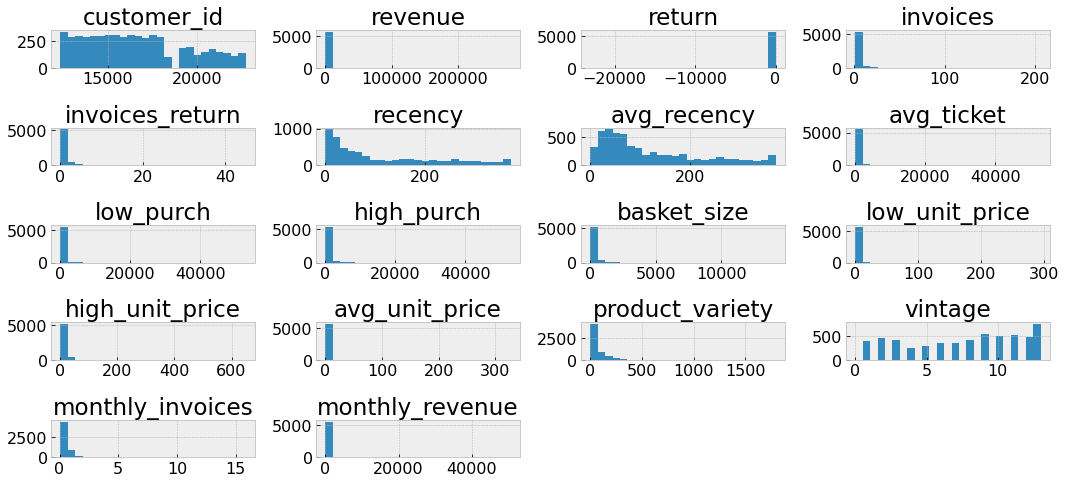

In [61]:
df4.hist(bins = 25);
plt.tight_layout()

### 4.1.1 Monthly revenue

In [62]:
print('Quantiles:')
print(df4['monthly_revenue'].quantile([0, .25, .5, .75, .9, .95, .99, 1]))
print('\nMax values:')
df4[['customer_id', 'monthly_revenue']].sort_values('monthly_revenue').tail()

Quantiles:
0.00        0.035000
0.25       37.268333
0.50      104.160000
0.75      245.960000
0.90      494.160769
0.95      804.988462
0.99     4194.933846
1.00    50653.910000
Name: monthly_revenue, dtype: float64

Max values:


customer_id  monthly_revenue
3722        17450     14965.445385
4193        18102     19973.638462
1688        14646     23261.501667
5568        22312     26470.470000
5598        22383     50653.910000

<AxesSubplot:>

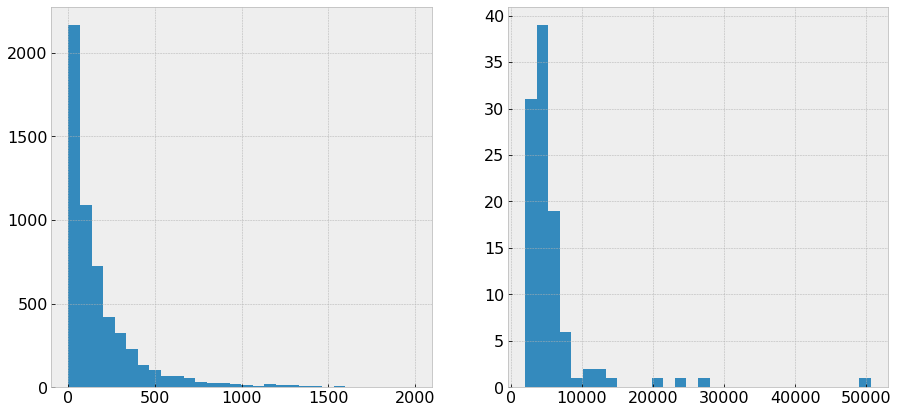

In [63]:
plt.subplot(121)
df4[df4['monthly_revenue'] < 2000]['monthly_revenue'].hist(bins = 30)

plt.subplot(122)
df4[df4['monthly_revenue'] >= 2000]['monthly_revenue'].hist(bins = 30)

In [64]:
df4[df4['monthly_revenue'] == df4['monthly_revenue'].max()]

customer_id   revenue  return  invoices  invoices_return  recency  \
5598        22383  50653.91     0.0         1              0.0       25   

      avg_recency  avg_ticket  low_purch  high_purch  basket_size  \
5598         25.0    50653.91   50653.91    50653.91      13956.0   

             country  low_unit_price  high_unit_price  avg_unit_price  \
5598  United Kingdom             1.0            14.95        4.742525   

      product_variety  vintage  monthly_invoices  monthly_revenue  
5598               99        1               1.0         50653.91

### 4.1.2 Monthly invoices

In [65]:
print('Quantiles:')
print(df4['monthly_invoices'].quantile([0, .25, .5, .75, .9, .95, .99, 1]))
print('\nMax values:')
df4[['customer_id', 'monthly_invoices']].sort_values('monthly_invoices').tail()

Quantiles:
0.00     0.076923
0.25     0.153846
0.50     0.333333
0.75     0.615385
0.90     1.000000
0.95     1.333333
0.99     2.846154
1.00    15.846154
Name: monthly_invoices, dtype: float64

Max values:


customer_id  monthly_invoices
1660        14606          7.000000
561         13089          7.461538
4003        17841          9.538462
1878        14911         15.230769
325         12748         15.846154

<AxesSubplot:>

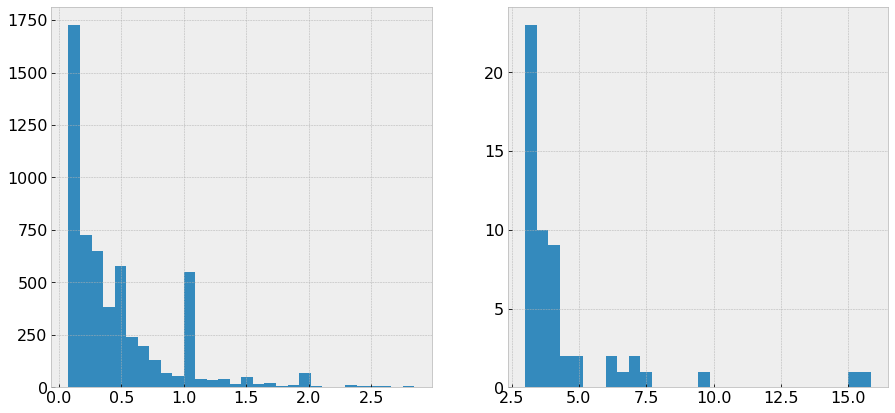

In [66]:
# df4['monthly_invoices'].hist(bins = 30)
plt.subplot(121)
df4[df4['monthly_invoices'] < 3]['monthly_invoices'].hist(bins = 30)

plt.subplot(122)
df4[df4['monthly_invoices'] >= 3]['monthly_invoices'].hist(bins = 30)

In [67]:
df4[df4['monthly_invoices'] > 15]

customer_id    revenue   return  invoices  invoices_return  recency  \
325         12748   32317.32 -1830.79       206             11.0        0   
1878        14911  136275.72 -7393.59       198             44.0        1   

      avg_recency  avg_ticket  low_purch  high_purch  basket_size  \
325      1.810680  156.880194       0.95      2026.7   123.839806   
1878     1.883838  688.261212       1.45      4345.1   404.944444   

             country  low_unit_price  high_unit_price  avg_unit_price  \
325   United Kingdom            0.04            29.95        2.373651   
1878            EIRE            0.04           165.00        3.381943   

      product_variety  vintage  monthly_invoices  monthly_revenue  
325              1767       13         15.846154      2485.947692  
1878             1791       13         15.230769     10482.747692

### 4.1.3 Avg ticket

In [70]:
print('Quantiles:')
print(df4['avg_ticket'].quantile([0, .25, .5, .75, .9, .95, .99, 1]))
print('\nMax values:')
df4[['customer_id', 'avg_ticket']].sort_values('avg_ticket').tail()

Quantiles:
0.00        0.420000
0.25      159.363333
0.50      296.700000
0.75      485.870000
0.90     1166.650000
0.95     1839.860000
0.99     4801.220000
1.00    52940.940000
Name: avg_ticket, dtype: float64

Max values:


customer_id  avg_ticket
5549        22221    14855.53
4469        19296    18745.86
4796        20055    21389.60
5598        22383    50653.91
5568        22312    52940.94

<AxesSubplot:>

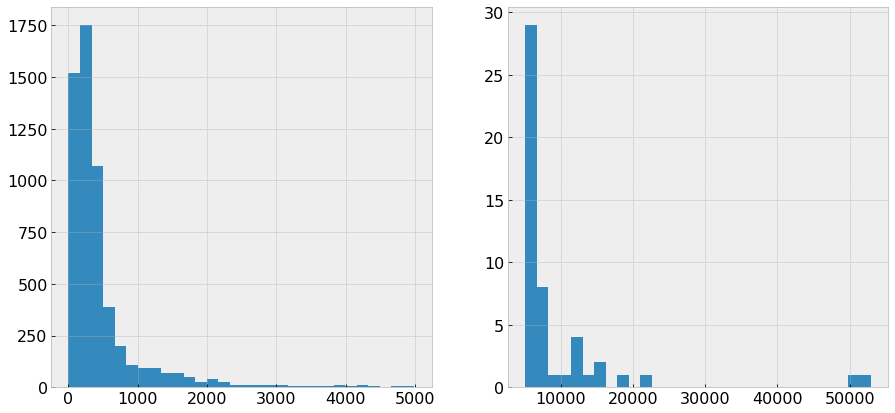

In [71]:
# df4['avg_ticket'].hist(bins = 30)
plt.subplot(121)
df4[df4['avg_ticket'] < 5000]['avg_ticket'].hist(bins = 30)

plt.subplot(122)
df4[df4['avg_ticket'] >= 5000]['avg_ticket'].hist(bins = 30)

In [72]:
df4[df4['avg_ticket'] > 40000]

customer_id   revenue  return  invoices  invoices_return  recency  \
5568        22312  52940.94     0.0         1              0.0       32   
5598        22383  50653.91     0.0         1              0.0       25   

      avg_recency  avg_ticket  low_purch  high_purch  basket_size  \
5568         32.0    52940.94   52940.94    52940.94      14149.0   
5598         25.0    50653.91   50653.91    50653.91      13956.0   

             country  low_unit_price  high_unit_price  avg_unit_price  \
5568  United Kingdom             1.0            16.09        4.939505   
5598  United Kingdom             1.0            14.95        4.742525   

      product_variety  vintage  monthly_invoices  monthly_revenue  
5568              101        2               0.5         26470.47  
5598               99        1               1.0         50653.91

### 4.1.4 Basket size

In [73]:
print('Quantiles:')
print(df4['basket_size'].quantile([0, .25, .5, .75, .9, .95, .99, 1]))
print('\nMax values:')
df4[['customer_id', 'basket_size']].sort_values('basket_size').tail()

Quantiles:
0.00        1.000000
0.25       75.000000
0.50      152.000000
0.75      290.625000
0.90      502.500000
0.95      732.000000
0.99     1641.333333
1.00    14149.000000
Name: basket_size, dtype: float64

Max values:


customer_id   basket_size
4796        20055   5963.000000
2501        15749   6009.333333
4306        18251   7824.000000
5598        22383  13956.000000
5568        22312  14149.000000

<AxesSubplot:>

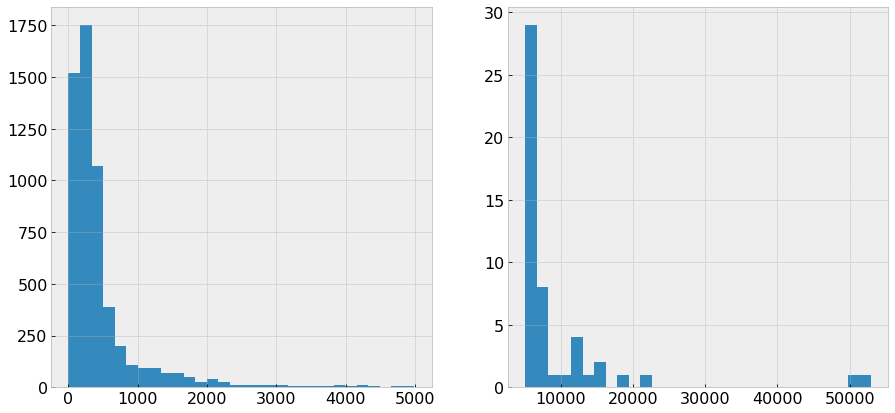

In [71]:
# df4['avg_ticket'].hist(bins = 30)
plt.subplot(121)
df4[df4['avg_ticket'] < 5000]['avg_ticket'].hist(bins = 30)

plt.subplot(122)
df4[df4['avg_ticket'] >= 5000]['avg_ticket'].hist(bins = 30)

In [72]:
df4[df4['avg_ticket'] > 40000]

customer_id   revenue  return  invoices  invoices_return  recency  \
5568        22312  52940.94     0.0         1              0.0       32   
5598        22383  50653.91     0.0         1              0.0       25   

      avg_recency  avg_ticket  low_purch  high_purch  basket_size  \
5568         32.0    52940.94   52940.94    52940.94      14149.0   
5598         25.0    50653.91   50653.91    50653.91      13956.0   

             country  low_unit_price  high_unit_price  avg_unit_price  \
5568  United Kingdom             1.0            16.09        4.939505   
5598  United Kingdom             1.0            14.95        4.742525   

      product_variety  vintage  monthly_invoices  monthly_revenue  
5568              101        2               0.5         26470.47  
5598               99        1               1.0         50653.91

### 4.1.5 Country

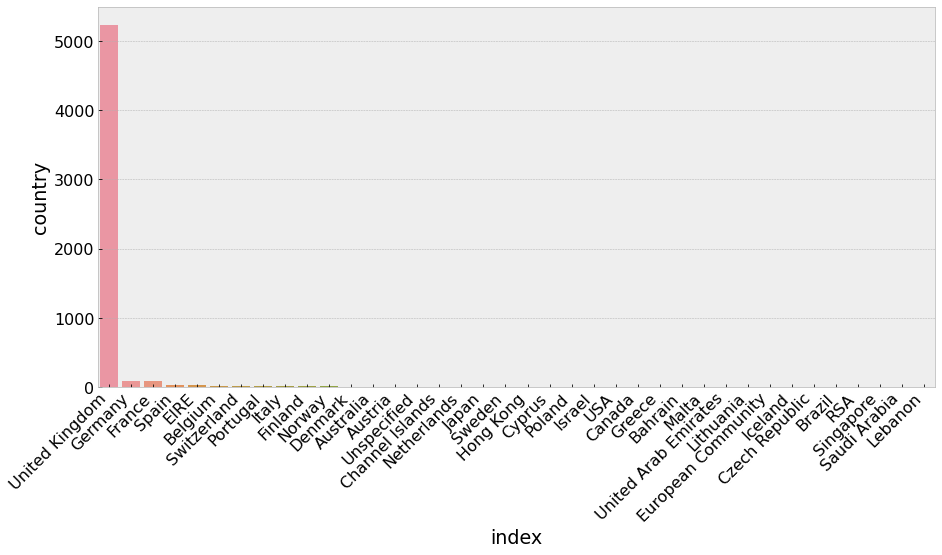

In [29]:
aux = df4['country'].value_counts().reset_index()
sns.barplot(data = aux, x = 'index', y = 'country')
plt.xticks(rotation = 45, horizontalalignment = 'right');

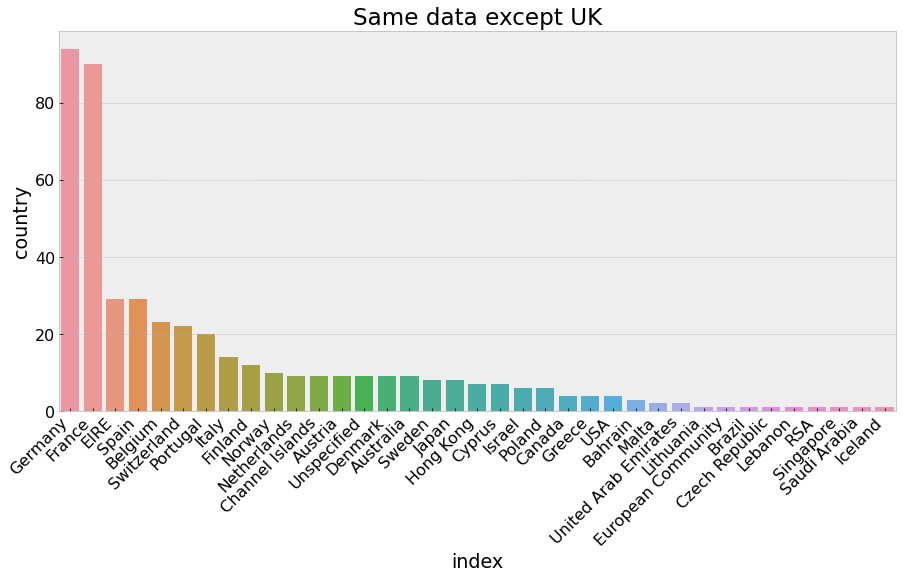

In [30]:
aux = df4[df4['country'] != 'United Kingdom']['country'].value_counts().reset_index()
sns.barplot(data = aux, x = 'index', y = 'country')
plt.xticks(rotation = 45, horizontalalignment = 'right')
plt.title('Same data except UK');

In [13]:
df4['country'].value_counts(normalize = True)

United Kingdom          0.903531
Germany                 0.021694
France                  0.020078
Spain                   0.006693
Belgium                 0.005308
Portugal                0.004385
Switzerland             0.004385
Italy                   0.003231
Finland                 0.002769
Norway                  0.002308
Netherlands             0.002077
Austria                 0.002077
Channel Islands         0.002077
Denmark                 0.002077
Australia               0.002077
Sweden                  0.001846
Japan                   0.001846
Cyprus                  0.001616
Poland                  0.001385
USA                     0.000923
Canada                  0.000923
Greece                  0.000923
Unspecified             0.000923
Israel                  0.000692
EIRE                    0.000692
United Arab Emirates    0.000462
Bahrain                 0.000462
Malta                   0.000462
Saudi Arabia            0.000231
Singapore               0.000231
Iceland   

## 4.2 Análise bivariada

<Figure size 1440x720 with 0 Axes>

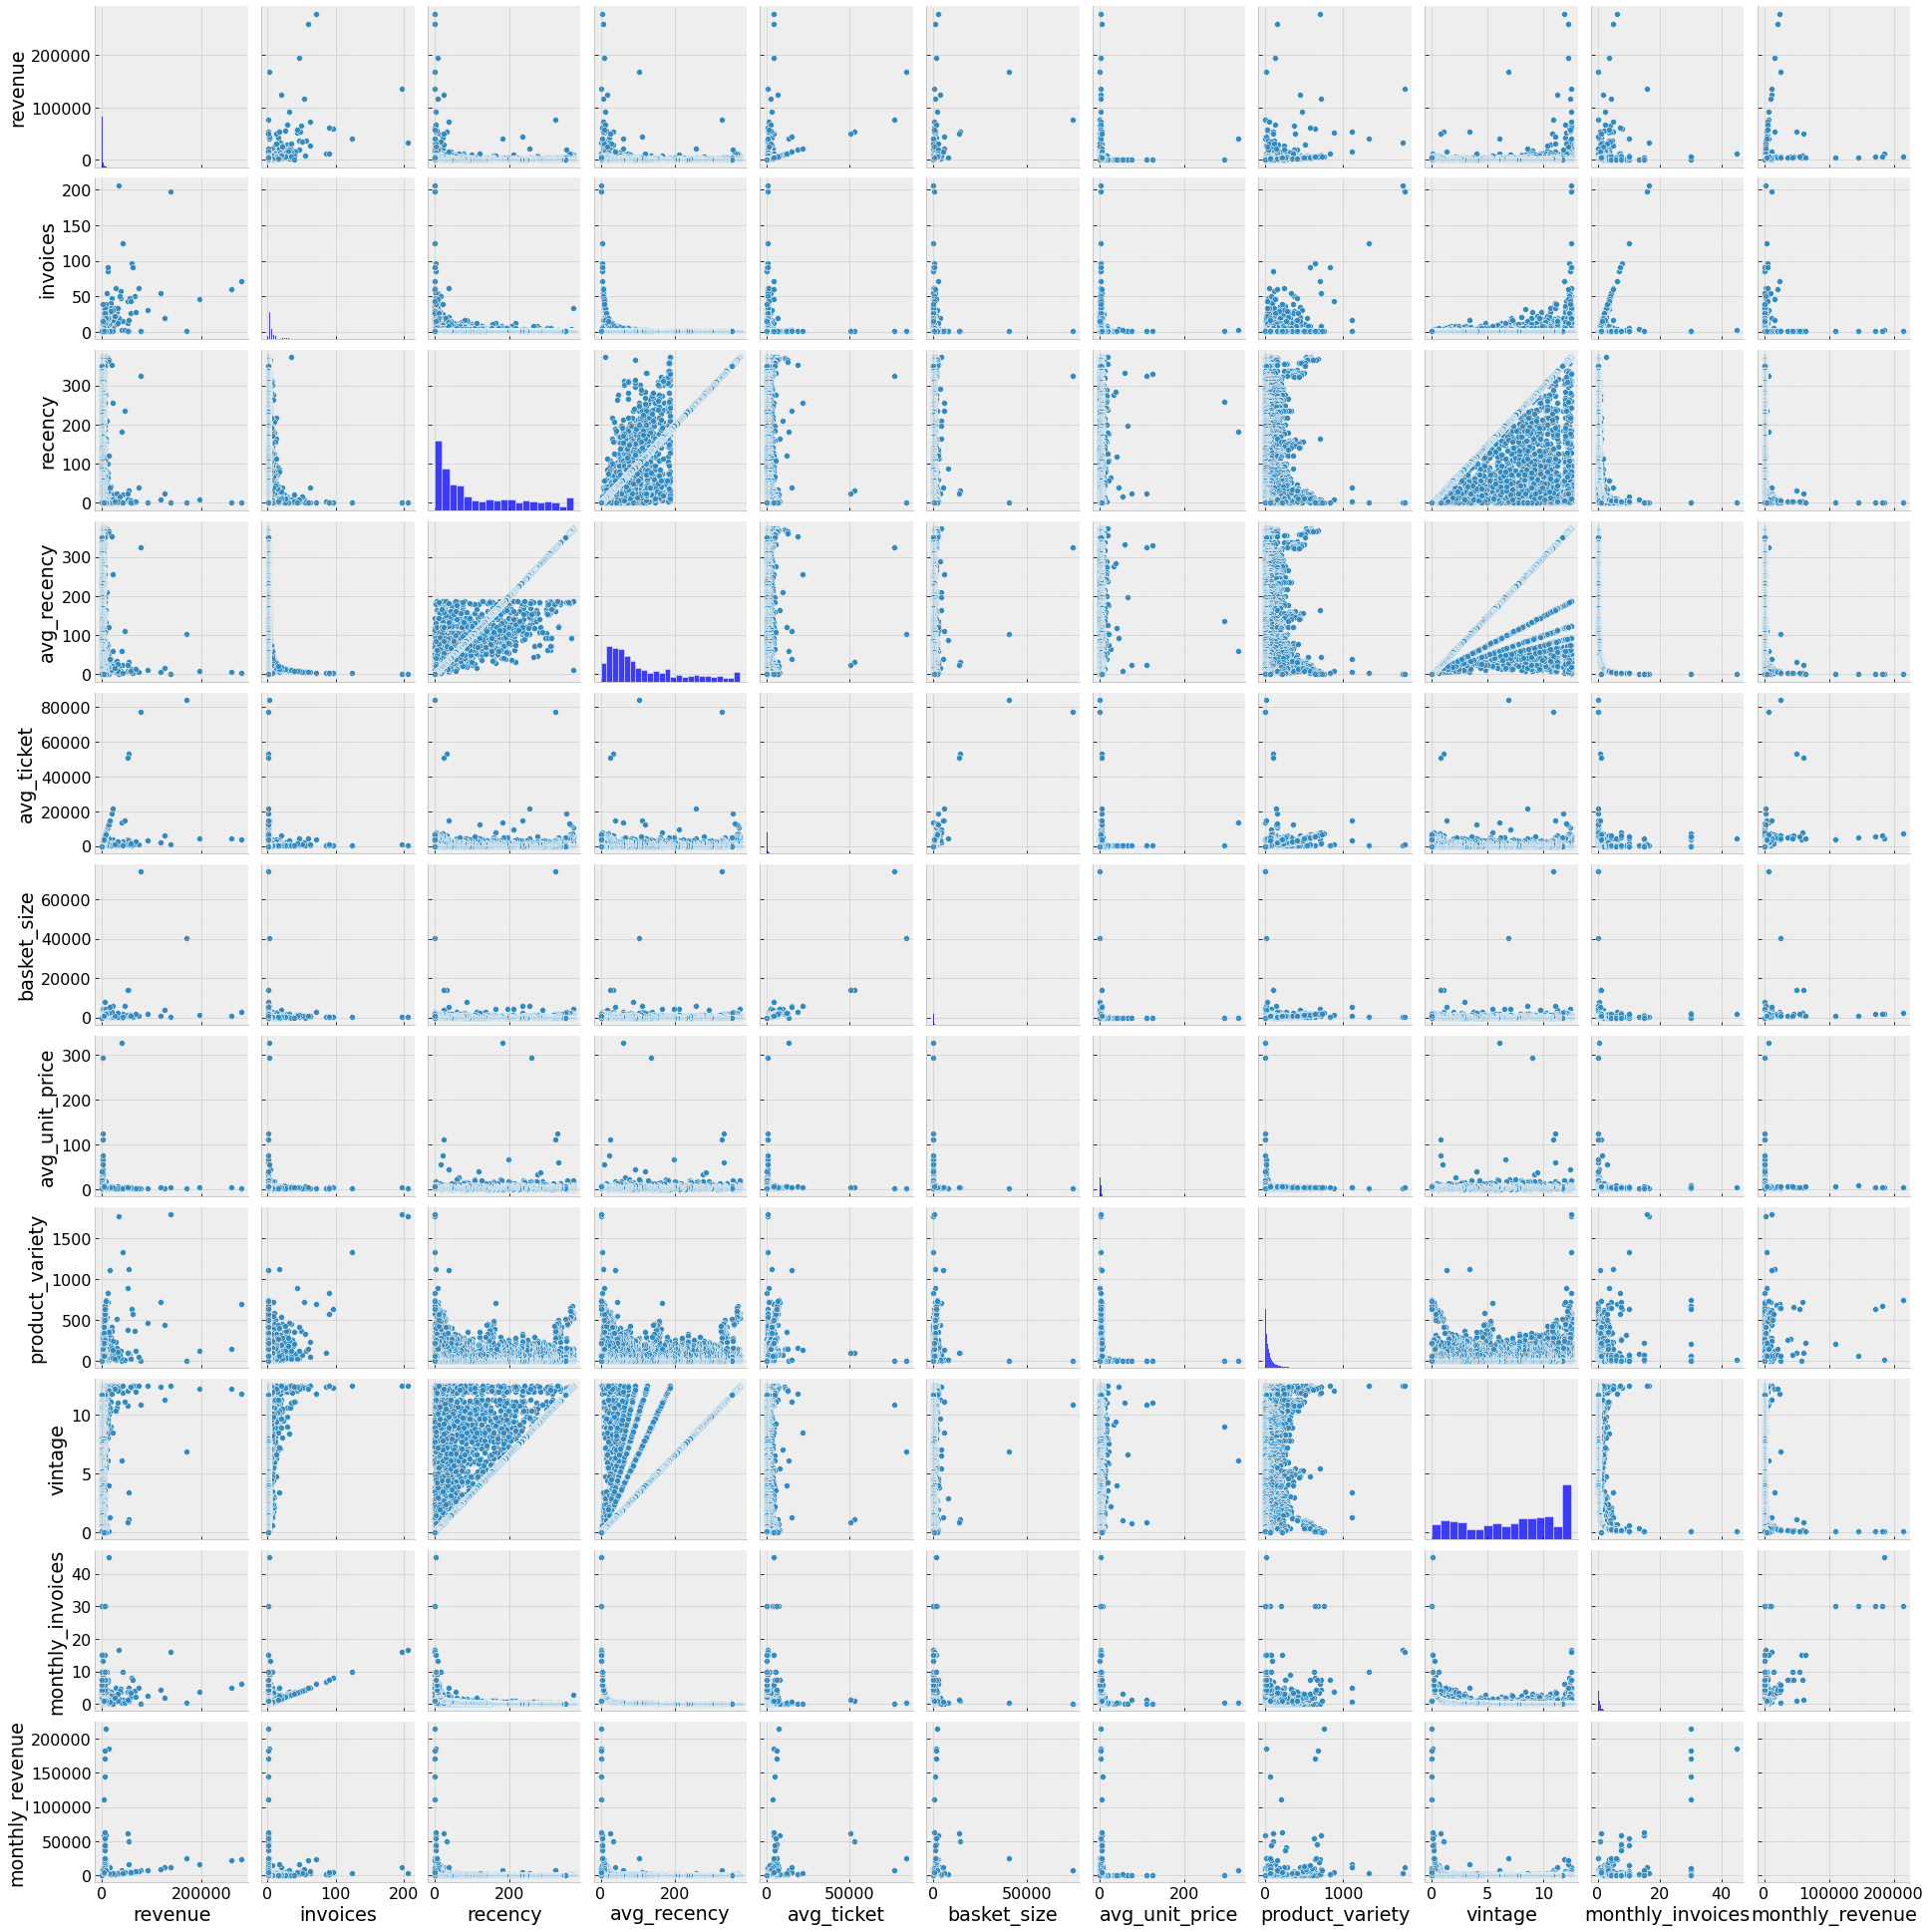

In [35]:
plt.figure(figsize = (20, 10))
drop_cols = ['customer_id', 'return', 'invoices_return', 'low_purch', 'high_purch', 'low_unit_price', 'high_unit_price', 'country']
sns.pairplot(df4.drop(columns = drop_cols))

## 4.3 Análise multivariada

<AxesSubplot:>

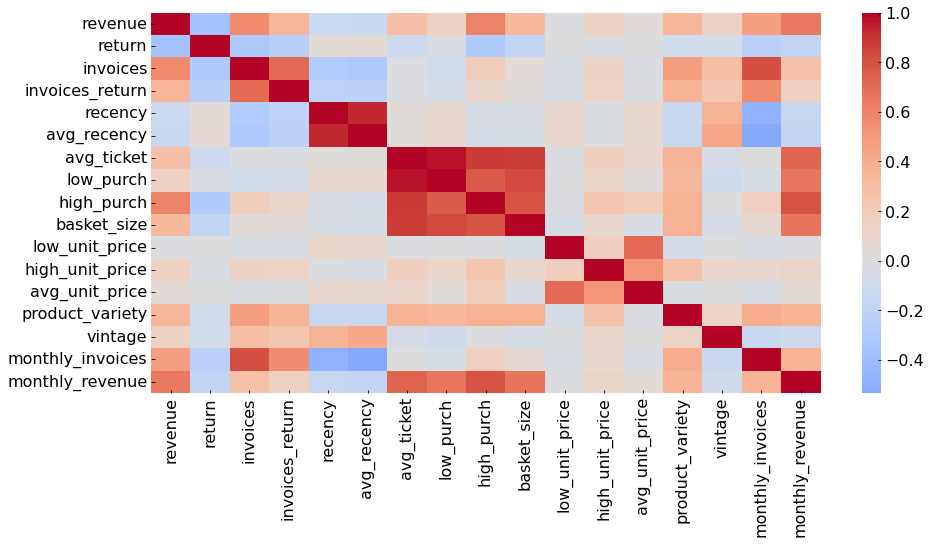

In [79]:
correlation = df4.drop(columns = ['customer_id', 'country']).corr(method = 'pearson')
sns.heatmap(correlation, 
#             annot = True, 
            cmap = 'coolwarm', center = 0)

# 5 Preparação dos dados

## Data checkpoint

In [7]:
df5 = df4.copy()

In [8]:
df5.to_csv('../data/interim/c3_df5.csv', index = False)

In [64]:
df5 = pd.read_csv('../data/interim/c3_df5.csv')

## 5.1 Normalização

*Sem normalizações*

## 5.2 Rescaling

In [65]:
# rs = RobustScaler()
rs = MinMaxScaler()
# revenue
df5['revenue'] = rs.fit_transform(df5[['revenue']].values)
pickle.dump(rs, open('../src/features/revenue_scaler.pkl', 'wb'))

# return
df5['return'] = rs.fit_transform(df5[['return']].values)
pickle.dump(rs, open('../src/features/return_scaler.pkl', 'wb'))

# invoices
df5['invoices'] = rs.fit_transform(df5[['invoices']].values)
pickle.dump(rs, open('../src/features/invoices_scaler.pkl', 'wb'))

# invoices_return
df5['invoices_return'] = rs.fit_transform(df5[['invoices_return']].values)
pickle.dump(rs, open('../src/features/invoices_return_scaler.pkl', 'wb'))

# recency
df5['recency'] = rs.fit_transform(df5[['recency']].values)
pickle.dump(rs, open('../src/features/recency_scaler.pkl', 'wb'))

# avg_recency
df5['avg_recency'] = rs.fit_transform(df5[['avg_recency']].values)
pickle.dump(rs, open('../src/features/avg_recency_scaler.pkl', 'wb'))

# avg_ticket
df5['avg_ticket'] = rs.fit_transform(df5[['avg_ticket']].values)
pickle.dump(rs, open('../src/features/avg_ticket_scaler.pkl', 'wb'))

# low_purch
df5['low_purch'] = rs.fit_transform(df5[['low_purch']].values)
pickle.dump(rs, open('../src/features/low_purch_scaler.pkl', 'wb'))

# high_purch
df5['high_purch'] = rs.fit_transform(df5[['high_purch']].values)
pickle.dump(rs, open('../src/features/high_purch_scaler.pkl', 'wb'))

# basket_size
df5['basket_size'] = rs.fit_transform(df5[['basket_size']].values)
pickle.dump(rs, open('../src/features/basket_size_scaler.pkl', 'wb'))

# low_unit_price
df5['low_unit_price'] = rs.fit_transform(df5[['low_unit_price']].values)
pickle.dump(rs, open('../src/features/low_unit_price_scaler.pkl', 'wb'))

# high_unit_price
df5['high_unit_price'] = rs.fit_transform(df5[['high_unit_price']].values)
pickle.dump(rs, open('../src/features/high_unit_price_scaler.pkl', 'wb'))

# avg_unit_price
df5['avg_unit_price'] = rs.fit_transform(df5[['avg_unit_price']].values)
pickle.dump(rs, open('../src/features/avg_unit_price_scaler.pkl', 'wb'))

# product_variety
df5['product_variety'] = rs.fit_transform(df5[['product_variety']].values)
pickle.dump(rs, open('../src/features/product_variety_scaler.pkl', 'wb'))

# vintage
df5['vintage'] = rs.fit_transform(df5[['vintage']].values)
pickle.dump(rs, open('../src/features/vintage_scaler.pkl', 'wb'))

# monthly_invoices
df5['monthly_invoices'] = rs.fit_transform(df5[['monthly_invoices']].values)
pickle.dump(rs, open('../src/features/monthly_invoices_scaler.pkl', 'wb'))

# monthly_revenue
df5['monthly_revenue'] = rs.fit_transform(df5[['monthly_revenue']].values)
pickle.dump(rs, open('../src/features/monthly_revenue_scaler.pkl', 'wb'))

## 5.3 Transformação

In [66]:
# country - label encoding
le = LabelEncoder()
df5['country'] = le.fit_transform(df5['country'])
pickle.dump(le, open('../src/features/country_encoder.pkl', 'wb'))

## 5.4 Espaços embedding

In [9]:
X = df5.copy()

### 5.4.1 PCA

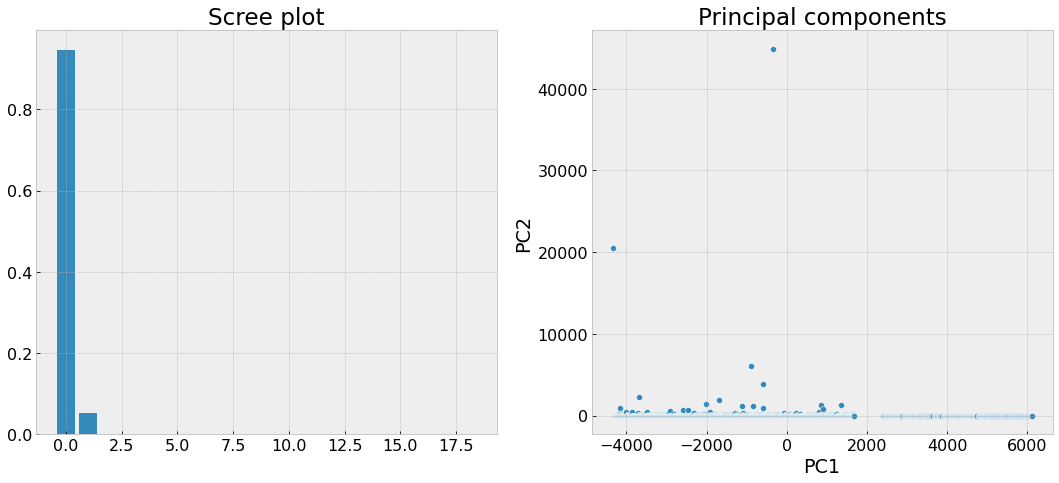

In [18]:
fig, axs = plt.subplots(1, 2)

pca = PCA(n_components = X.shape[1])
principal_components = pca.fit_transform(X)
features = range(pca.n_components_)
df_pca = pd.DataFrame(principal_components)
axs[0].bar(features, pca.explained_variance_ratio_)
axs[0].set_title('Scree plot')

sns.scatterplot(data = df_pca, x = 0, y = 1, ax = axs[1])
axs[1].set_title('Principal components')
axs[1].set_xlabel('PC1')
axs[1].set_ylabel('PC2')

fig.tight_layout()

### 5.4.2 UMAP

<AxesSubplot:xlabel='0', ylabel='1'>

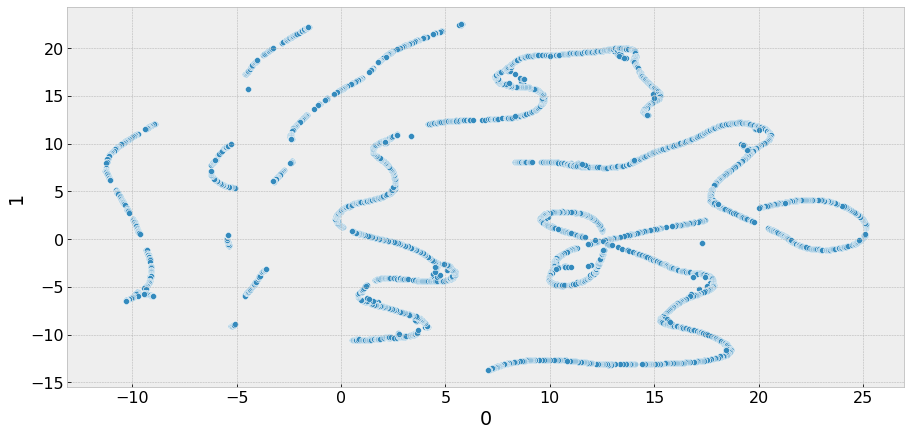

In [32]:
reducer = umap.UMAP(random_state = 73)
embedding = reducer.fit_transform(X)

df_umap = pd.DataFrame(embedding)

sns.scatterplot(data = df_umap, x = 0, y = 1)

### 5.4.3 t-SNE

C:\Users\Adm\anaconda3\envs\loyalty\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\Adm\anaconda3\envs\loyalty\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


<AxesSubplot:xlabel='0', ylabel='1'>

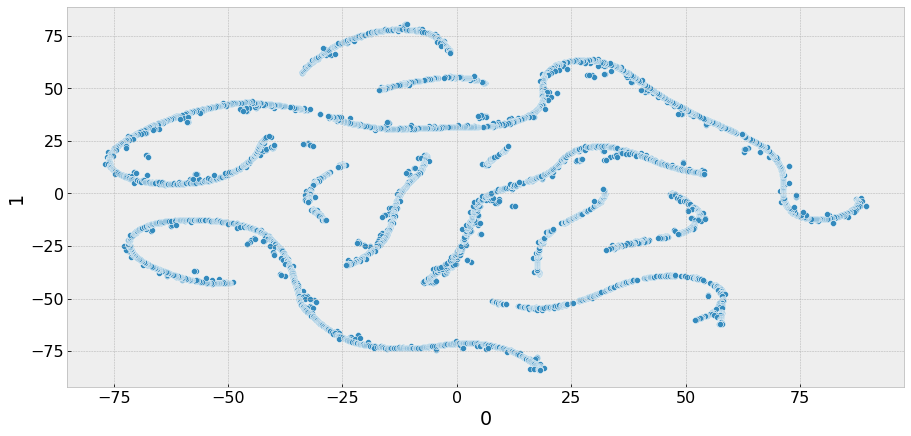

In [34]:
reducer = TSNE(n_components = 2, n_jobs = -1, random_state = 73)
embedding = reducer.fit_transform(X)

df_tsne = pd.DataFrame(embedding)

sns.scatterplot(data = df_tsne, x = 0, y = 1)

### 5.4.4 Árvore

In [48]:
# Dataset
x = X.drop(columns = ['customer_id', 'monthly_revenue'])
y = X['monthly_revenue']

# Model
rf = RandomForestRegressor(random_state = 73)

# Training
rf.fit(x, y)

# Leaves dataframe
df_leaves = pd.DataFrame(rf.apply(x))

<AxesSubplot:xlabel='0', ylabel='1'>

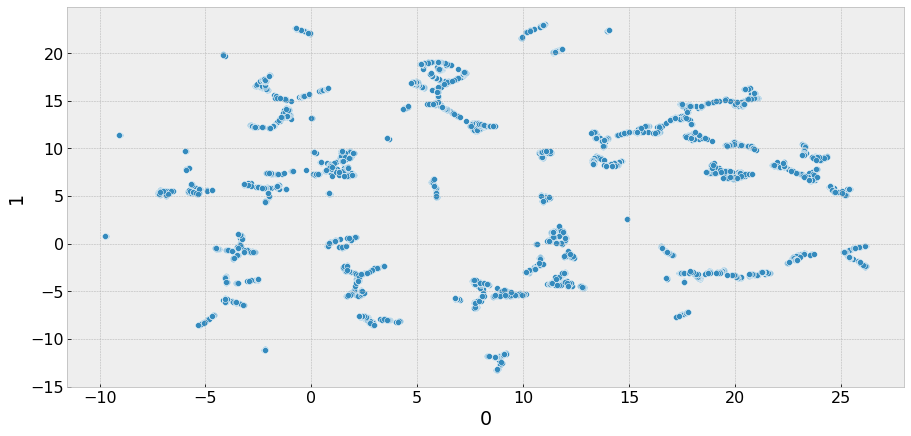

In [49]:
reducer = umap.UMAP(random_state = 73)
embedding = reducer.fit_transform(df_leaves)

df_umap = pd.DataFrame(embedding)

sns.scatterplot(data = df_umap, x = 0, y = 1)

# 6 Seleção das features

In [67]:
df6 = df5.copy()

# 7 Ajuste fino dos hyperparâmetros

## Data checkpoint

In [68]:
df7 = df6.copy()
X = df7.drop(['customer_id'], axis = 1)

In [69]:
df7.to_csv('../data/interim/c3_df7.csv', index = False)

In [18]:
df7 = pd.read_csv('../data/interim/c3_df7.csv')
X = df7.drop(['customer_id'], axis = 1)

## 7.1 K-means

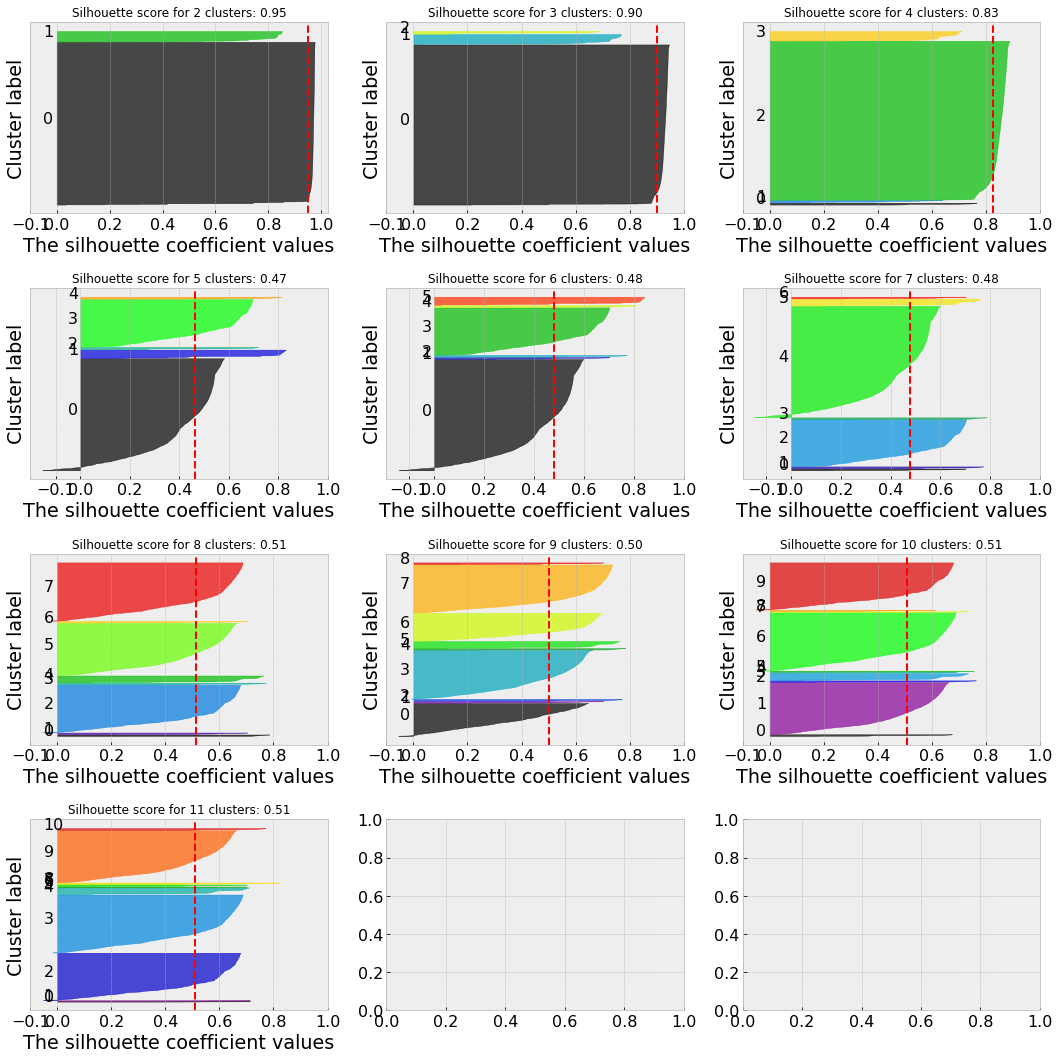

In [19]:
clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
kmeans_wss = []# Within-cluster sum of squares
kmeans_ss = []# Silhouette score
fig, axs = plt.subplots(4, 3, figsize = (15, 15))
for k in clusters:
    # Model
    kmeans_model = KMeans(init = 'random',
                          n_clusters = k,
                          max_iter = 300,
                          random_state = 73)
    
    # Training
    kmeans_model.fit(X)
    
    # Predict
    labels = kmeans_model.predict(X)
    
    # Performance
    kmeans_wss.append(kmeans_model.inertia_)
    kmeans_ss.append(silhouette_score(X, labels, metric='euclidean'))
    
    # Silhouette analysis
    r, c = divmod(clusters.index(k), 3)# 3 colunas no array axs
    silhouette_plot(X, labels, axs[r][c])
fig.tight_layout()

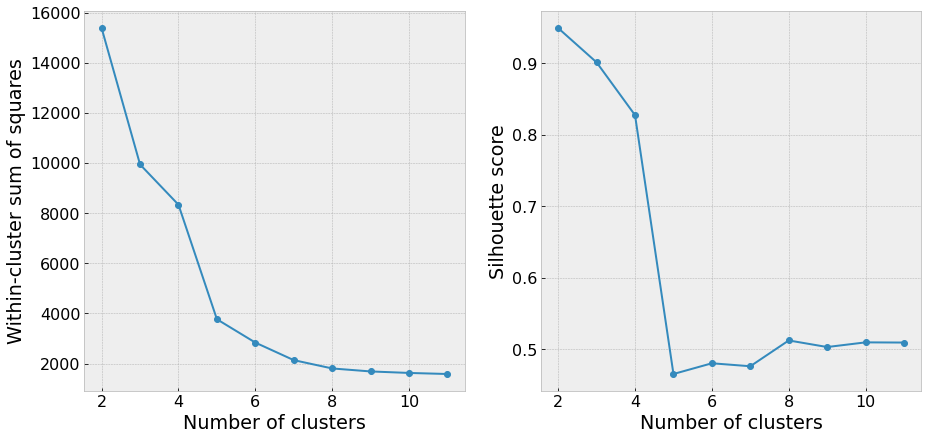

In [20]:
plt.subplot(1,2,1)
plt.plot(clusters, kmeans_wss, '-o')
plt.xlabel('Number of clusters')
plt.ylabel('Within-cluster sum of squares')

plt.subplot(1,2,2)
plt.plot(clusters, kmeans_ss, '-o')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score');

## 7.2 GMM

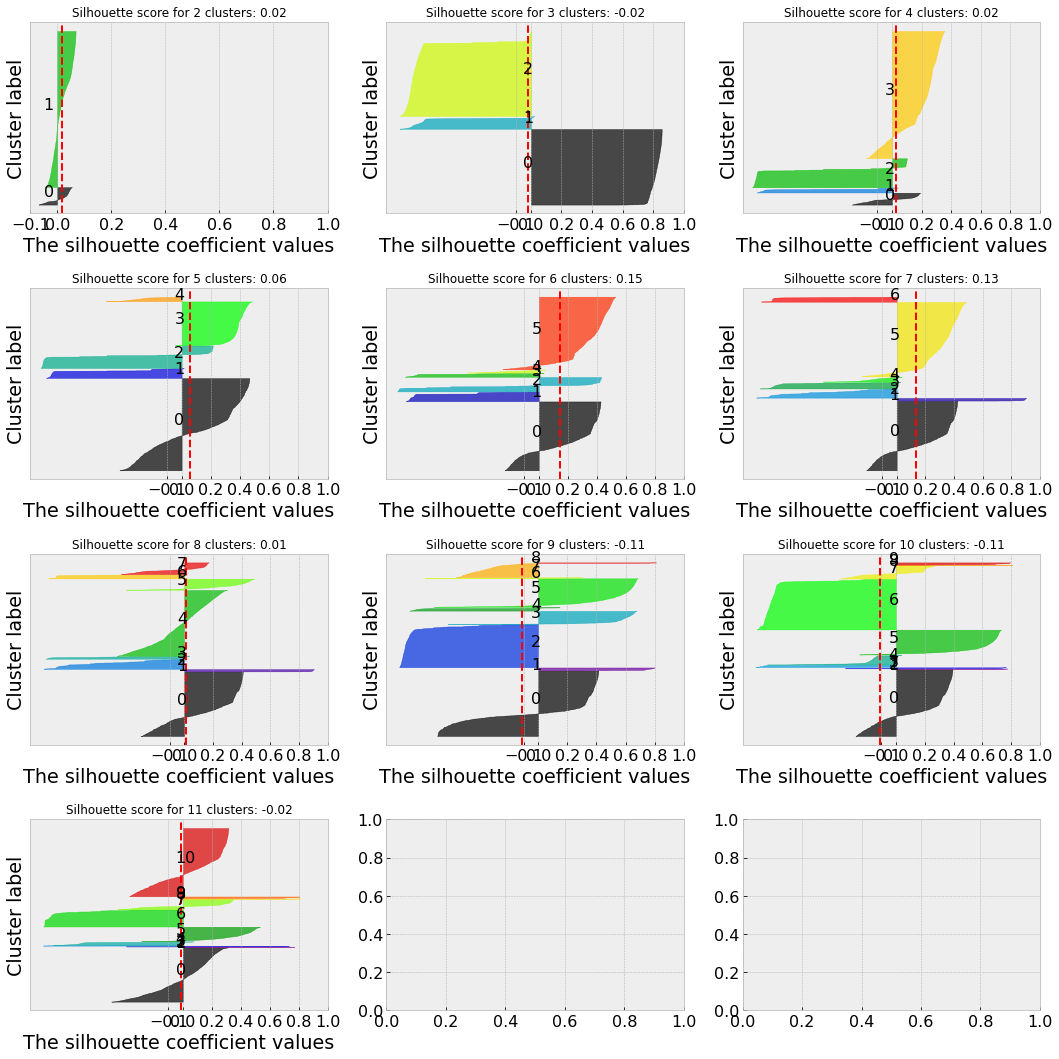

In [22]:
clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
gmm_ss = []# Silhouette score
fig, axs = plt.subplots(4, 3, figsize = (15, 15))
for k in clusters:
    # Model
    gmm_model = GaussianMixture(n_components = k,
                                random_state = 73)
    
    # Training
    gmm_model.fit(X)
    
    # Predict
    labels = gmm_model.predict(X)
    
    # Performance
    gmm_ss.append(silhouette_score(X, labels, metric='euclidean'))
    
    # Silhouette analysis
    r, c = divmod(clusters.index(k), 3)# 3 colunas no array axs
    silhouette_plot(X, labels, axs[r][c])
fig.tight_layout()

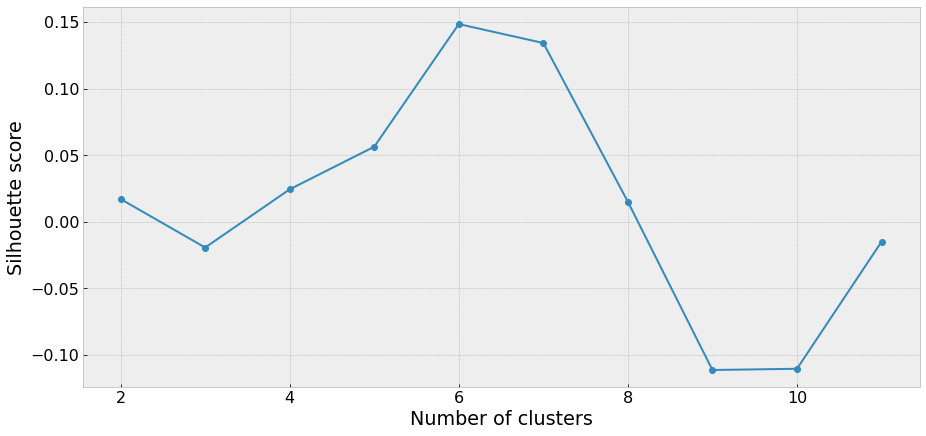

In [23]:
plt.plot(clusters, gmm_ss, '-o')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score');

## 7.3 Hierarchical Clustering

In [25]:
hc_model = hc.linkage(X, 'ward')

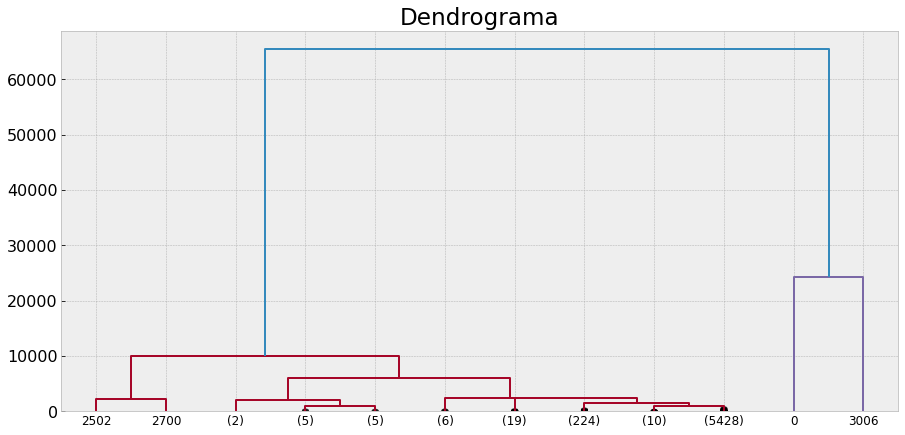

In [8]:
hc.dendrogram(hc_model, 
              truncate_mode = 'lastp', 
              p = 12, 
              show_contracted = True)
plt.plot()
plt.title('Dendrograma');

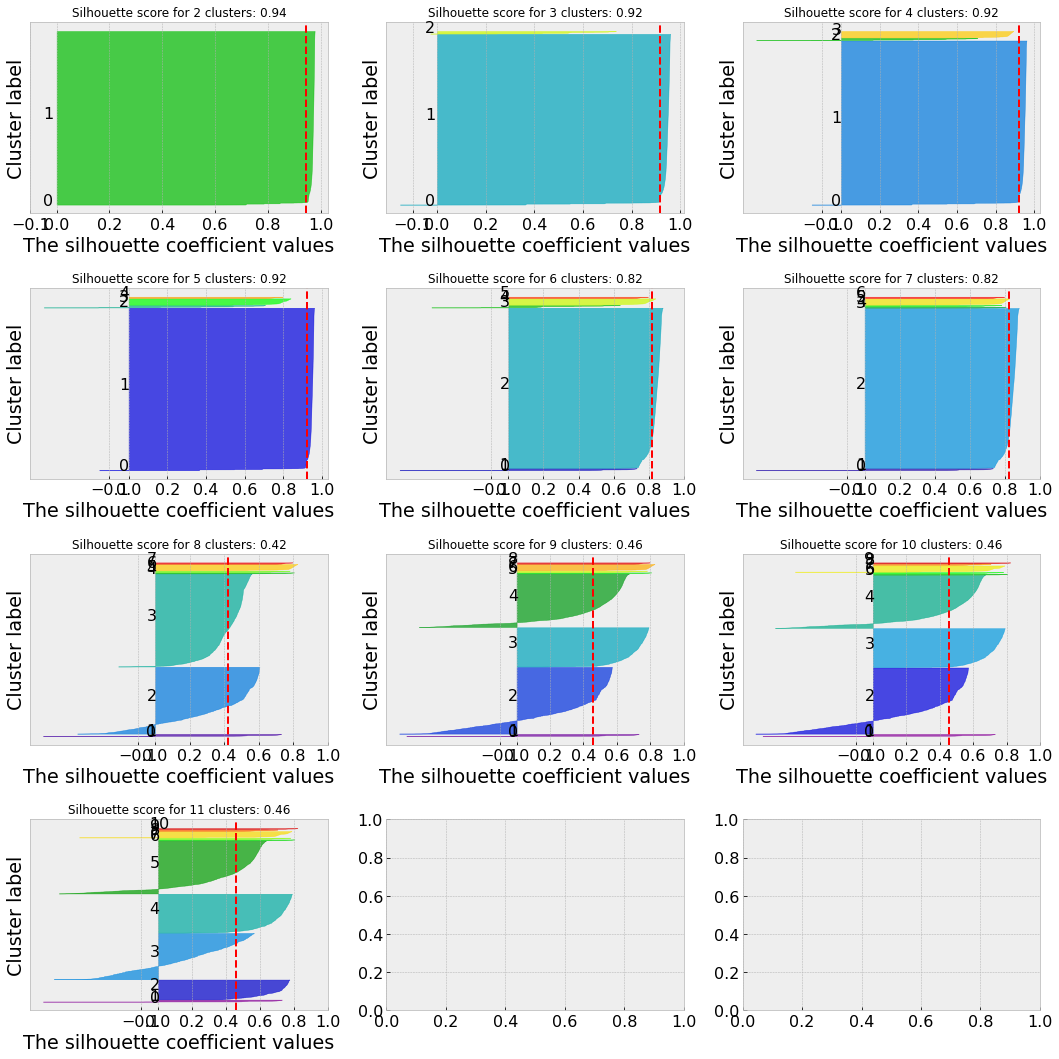

In [26]:
clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
hc_ss = []# Silhouette score
fig, axs = plt.subplots(4, 3, figsize = (15, 15))
for k in clusters:
    # Predict
    labels = hc.fcluster(hc_model, k, criterion = 'maxclust')
    
    # Performance
    hc_ss.append(silhouette_score(X, labels, metric='euclidean'))
    
    # Silhouette analysis
    r, c = divmod(clusters.index(k), 3)# 3 colunas no array axs
    silhouette_plot(X, labels, axs[r][c])
fig.tight_layout()

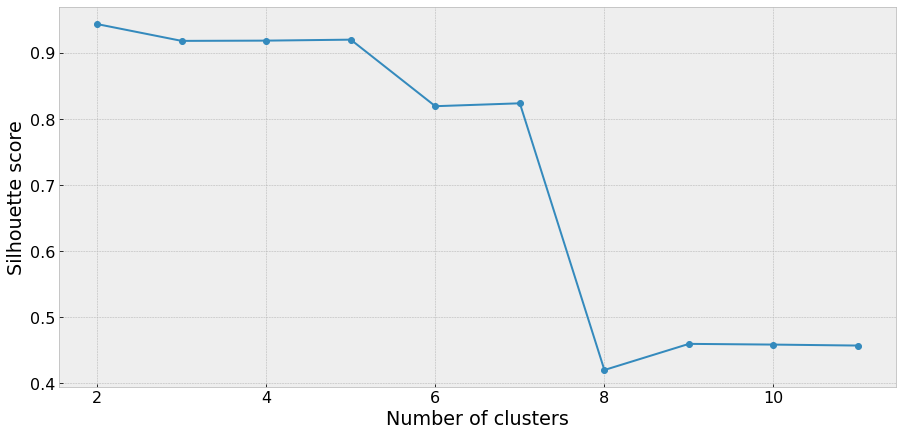

In [27]:
plt.plot(clusters, hc_ss, '-o')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score');

## 7.4 DBSCAN

In [93]:
eps = .15
min_samples = 20

# Model
dbscan_model = DBSCAN(eps = eps, min_samples = min_samples)

# Training & predict
labels = dbscan_model.fit_predict(X)

# Performance
dbscan_ss = silhouette_score(X, labels, metric='euclidean')
print('Silhouette: {:.3f}'.format(dbscan_ss))
print('# clusters: {}'.format(len(np.unique(labels))))
pd.value_counts(labels)

Silhouette: 0.308
# clusters: 2


 0    5599
-1     104
dtype: int64

In [28]:
dbscan_ss = [0]*len(clusters)

In [53]:
from sklearn.neighbors import NearestNeighbors

In [107]:
neighbors = NearestNeighbors(n_neighbors=min_samples).fit(X)
distances, indices = neighbors.kneighbors(X)
distances = np.sort(distances, axis = 0)

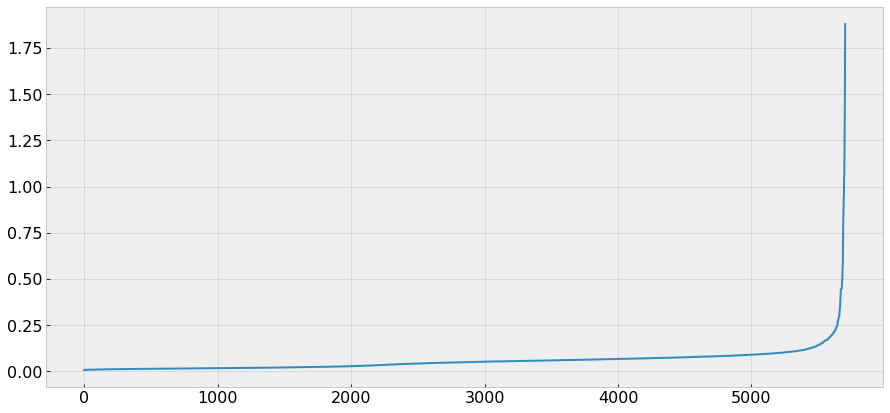

In [113]:
dist = distances[:,15]
plt.plot(dist)

## 7.5 Resultados

In [29]:
df_res = pd.DataFrame({'K-means': kmeans_ss, 
                       'GMM': gmm_ss, 
                       'Hierarchical': hc_ss, 
                       'DBSCAN': dbscan_ss}).T
df_res.columns = clusters
df_res.style.highlight_max(color = 'lightgreen', axis = 1)

# 8 Machine learning

## Data checkpoint

In [11]:
df8 = df7.copy()
X = df8.drop('customer_id', axis = 1)

## 8.1 K-means

In [12]:
n_clusters = 6

In [13]:
# Training
kmeans = KMeans(init = 'random',
                n_clusters = n_clusters,
                n_init = 10,
                max_iter = 300,
                random_state = 73)
kmeans.fit(X)

# Clustering
labels = kmeans.labels_

### 8.1.1 Cluster validation

In [14]:
print('WSS: {}'.format(kmeans.inertia_))
print('SS: {}'.format(silhouette_score(X, labels, metric='euclidean')))

WSS: 304600219.7338095
SS: 0.9464373333375178


# 9 Análise do cluster

In [42]:
df9 = df7.copy()
df9['cluster'] = labels

## 9.1 Inspeção visual

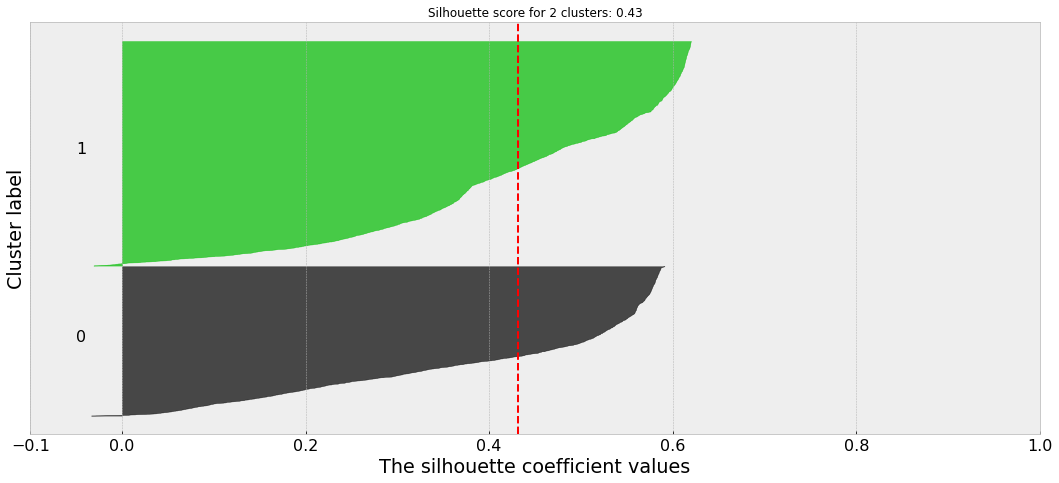

In [36]:
fig, ax = plt.subplots()

cluster_labels = kmeans.fit_predict(X)
silhouette_avg = silhouette_score(X, cluster_labels)

# Compute the silhouette scores for each sample
sample_silhouette_values = silhouette_samples(X, cluster_labels)

y_lower = 10
r, c = divmod(i, grid_cols)
for j in range(n_clusters):
    # Aggregate the silhouette scores for samples belonging to
    # cluster j, and sort them
    jth_cluster_silhouette_values = sample_silhouette_values[cluster_labels == j]

    jth_cluster_silhouette_values.sort()

    size_cluster_j = jth_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_j

    color = cm.nipy_spectral(float(j) / n_clusters)
    ax.fill_betweenx(np.arange(y_lower, y_upper),
                      0,
                      jth_cluster_silhouette_values,
                      facecolor=color,
                      edgecolor=color,
                      alpha=0.7)

    # Label the silhouette plots with their cluster numbers at the middle
    ax.text(-0.05, y_lower + 0.5 * size_cluster_j, str(j))

    # Compute the new y_lower for next plot
    y_lower = y_upper + 10  # 10 for the 0 samples

ax.set_xlabel("The silhouette coefficient values")
ax.set_ylabel("Cluster label")
ax.set_title(
    'Silhouette score for {} clusters: {:.2f}'.format(n_clusters, silhouette_avg),
    fontsize = 12
)

# The vertical line for average silhouette score of all the values
ax.axvline(x=silhouette_avg, color="red", linestyle="--")

ax.set_yticks([]) # Clear the yaxis labels / ticks
ax.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

fig.tight_layout()

### 9.1.1 3 features

fig = px.scatter_3d(df9, x = 'recency', y = 'invoices', z = 'revenue', color = 'cluster')
fig.show()

### 9.1.2 More than 3 features

In [28]:
df_plot = df9.drop(columns = 'customer_id')

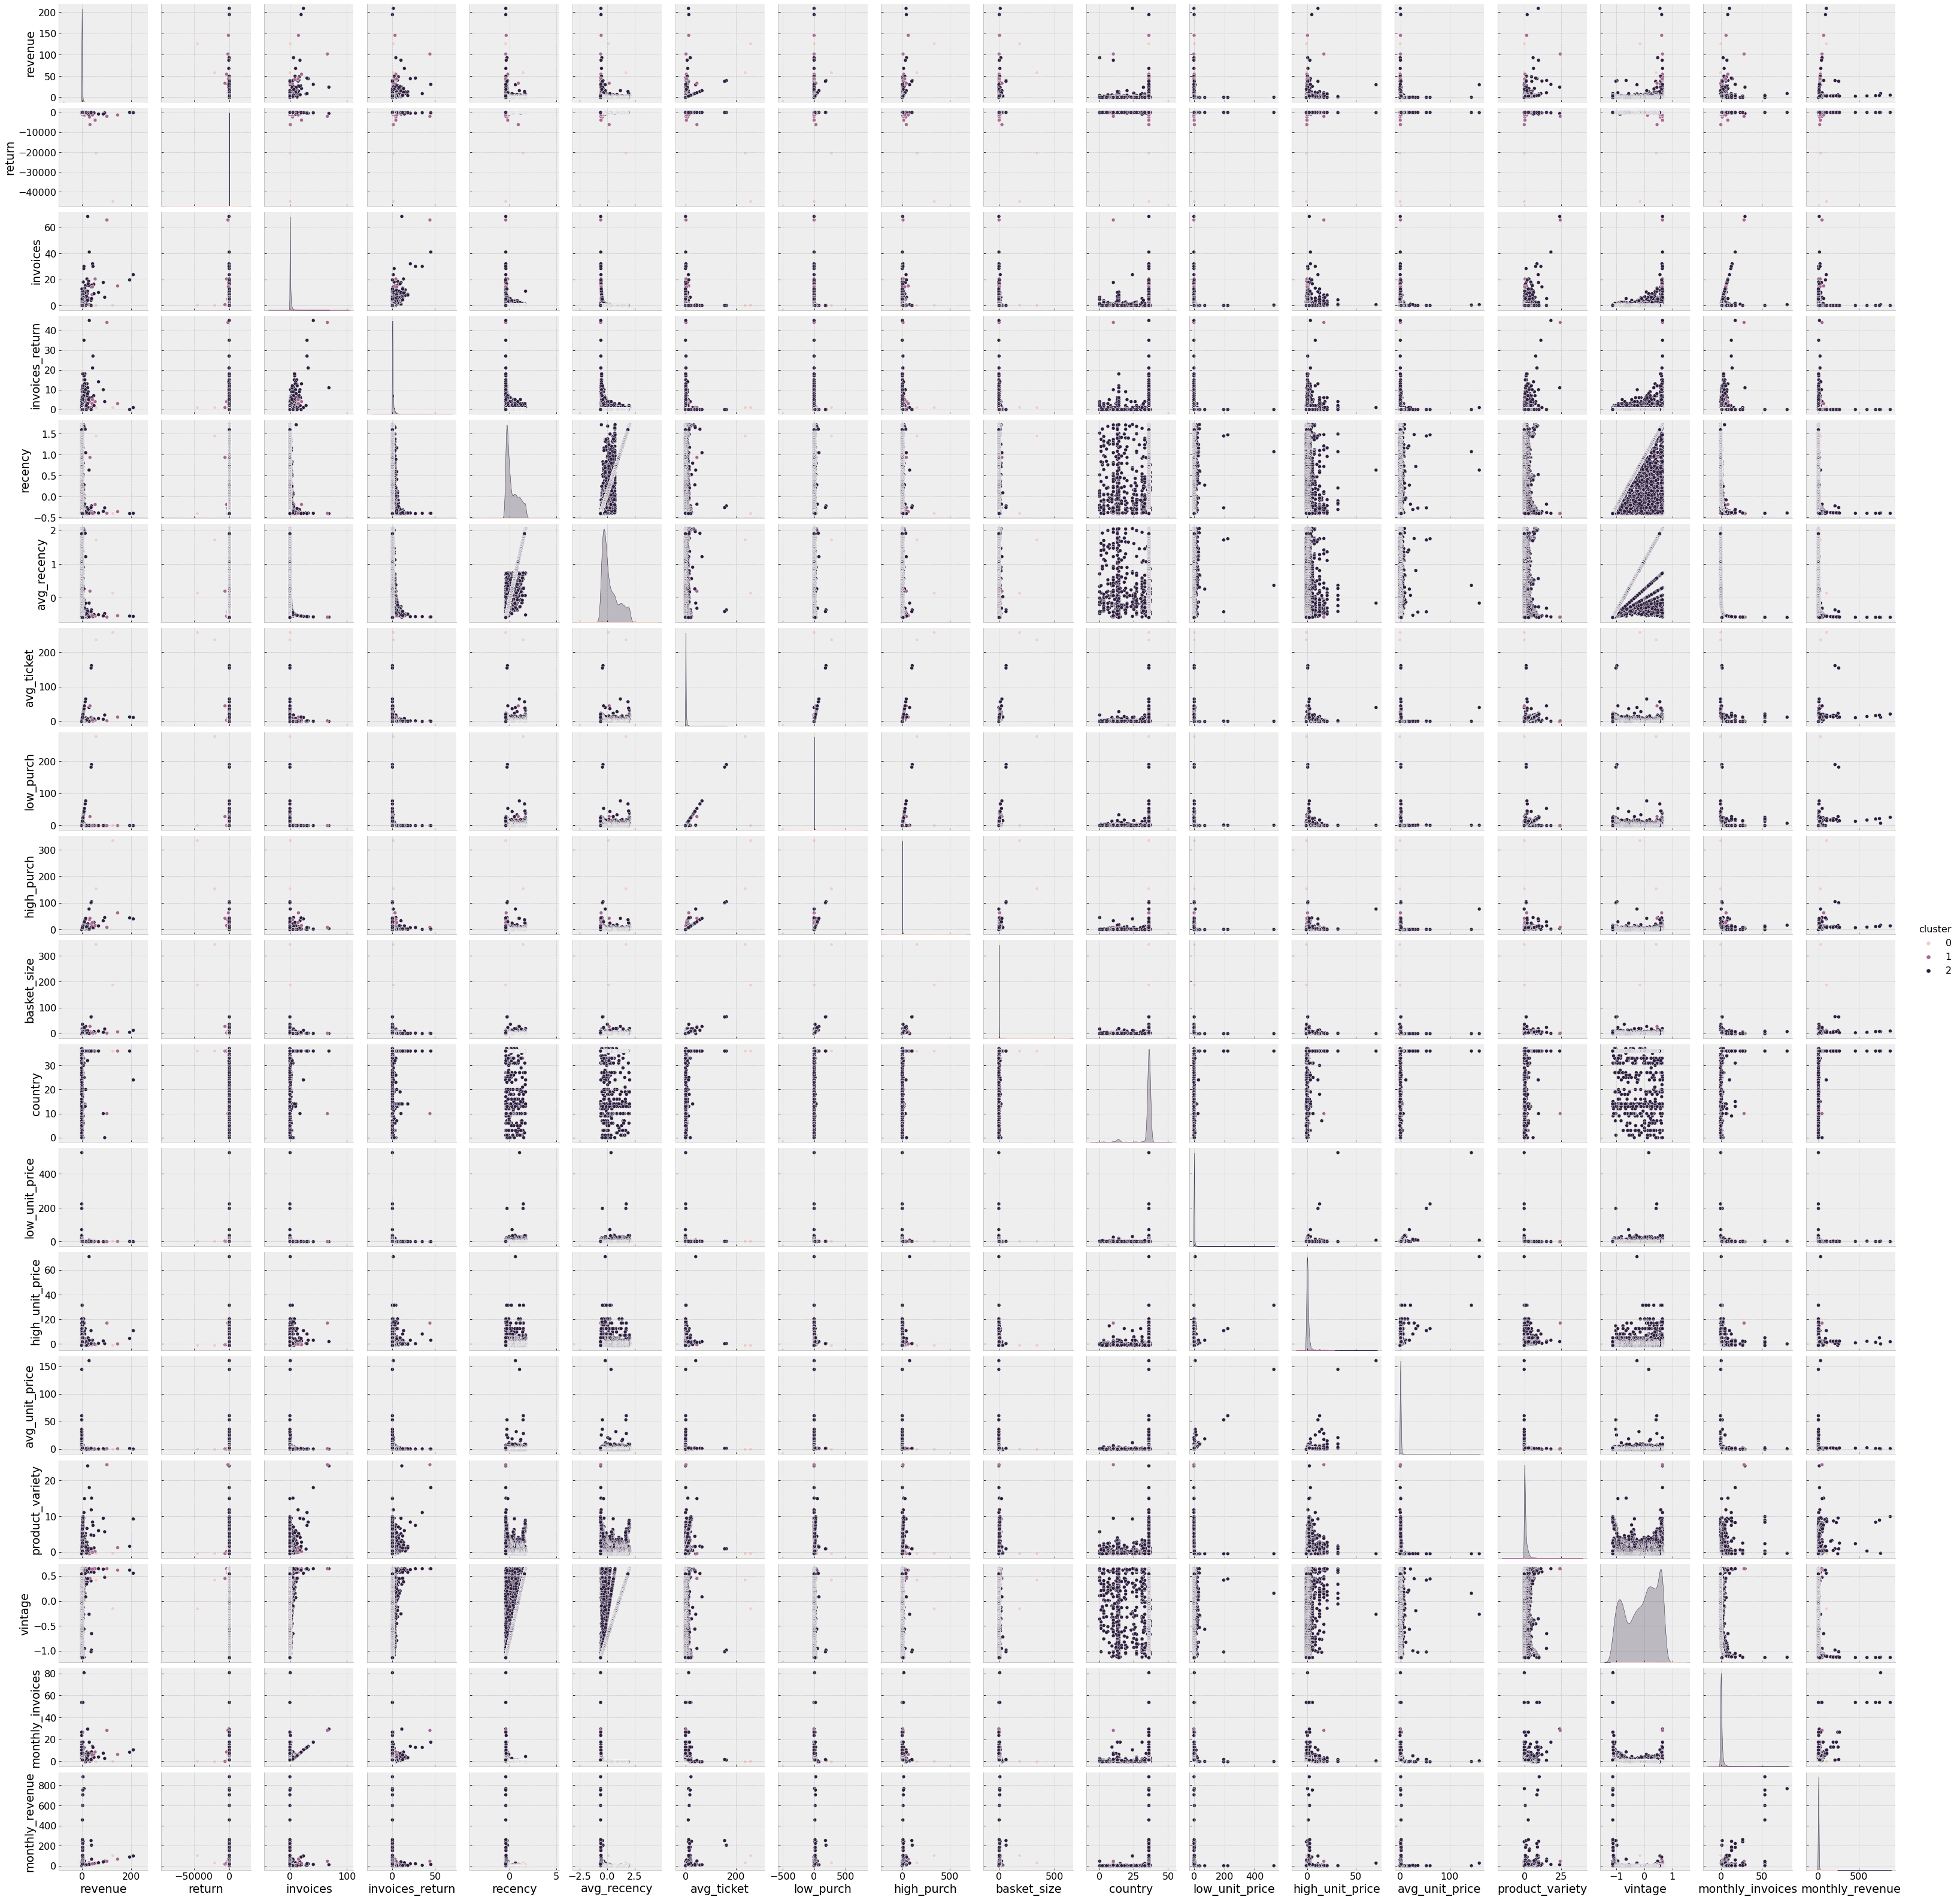

In [29]:
sns.pairplot(df_plot, hue = 'cluster')

## 9.2 Recuperar dados originais

In [43]:
# revenue
rs = pickle.load(open('../src/features/revenue_scaler.pkl', 'rb'))
df9['revenue'] = rs.inverse_transform(df9[['revenue']].values)

# return
rs = pickle.load(open('../src/features/return_scaler.pkl', 'rb'))
df9['return'] = rs.inverse_transform(df9[['return']].values)

# invoices
rs = pickle.load(open('../src/features/invoices_scaler.pkl', 'rb'))
df9['invoices'] = rs.inverse_transform(df9[['invoices']].values)

# invoices_return
rs = pickle.load(open('../src/features/invoices_return_scaler.pkl', 'rb'))
df9['invoices_return'] = rs.inverse_transform(df9[['invoices_return']].values)

# recency
rs = pickle.load(open('../src/features/recency_scaler.pkl', 'rb'))
df9['recency'] = rs.inverse_transform(df9[['recency']].values)

# avg_recency
rs = pickle.load(open('../src/features/avg_recency_scaler.pkl', 'rb'))
df9['avg_recency'] = rs.inverse_transform(df9[['avg_recency']].values)

# avg_ticket
rs = pickle.load(open('../src/features/avg_ticket_scaler.pkl', 'rb'))
df9['avg_ticket'] = rs.inverse_transform(df9[['avg_ticket']].values)

# low_purch
rs = pickle.load(open('../src/features/low_purch_scaler.pkl', 'rb'))
df9['low_purch'] = rs.inverse_transform(df9[['low_purch']].values)

# high_purch
rs = pickle.load(open('../src/features/high_purch_scaler.pkl', 'rb'))
df9['high_purch'] = rs.inverse_transform(df9[['high_purch']].values)

# basket_size
rs = pickle.load(open('../src/features/basket_size_scaler.pkl', 'rb'))
df9['basket_size'] = rs.inverse_transform(df9[['basket_size']].values)

# low_unit_price
rs = pickle.load(open('../src/features/low_unit_price_scaler.pkl', 'rb'))
df9['low_unit_price'] = rs.inverse_transform(df9[['low_unit_price']].values)

# high_unit_price
rs = pickle.load(open('../src/features/high_unit_price_scaler.pkl', 'rb'))
df9['high_unit_price'] = rs.inverse_transform(df9[['high_unit_price']].values)

# avg_unit_price
rs = pickle.load(open('../src/features/avg_unit_price_scaler.pkl', 'rb'))
df9['avg_unit_price'] = rs.inverse_transform(df9[['avg_unit_price']].values)

# product_variety
rs = pickle.load(open('../src/features/product_variety_scaler.pkl', 'rb'))
df9['product_variety'] = rs.inverse_transform(df9[['product_variety']].values)

# vintage
rs = pickle.load(open('../src/features/vintage_scaler.pkl', 'rb'))
df9['vintage'] = rs.inverse_transform(df9[['vintage']].values)

# monthly_invoices
rs = pickle.load(open('../src/features/monthly_invoices_scaler.pkl', 'rb'))
df9['monthly_invoices'] = rs.inverse_transform(df9[['monthly_invoices']].values)

# monthly_revenue
rs = pickle.load(open('../src/features/monthly_revenue_scaler.pkl', 'rb'))
df9['monthly_revenue'] = rs.inverse_transform(df9[['monthly_revenue']].values)

# country
le = pickle.load(open('../src/features/country_encoder.pkl', 'rb'))
df9['country'] = le.inverse_transform(df9['country'])

## 9.3 Descrição do perfil

In [44]:
# Número de clientes
df_cluster = df9[['cluster', 'customer_id']].groupby('cluster').count().reset_index()
df_cluster['customer%'] = 100*df_cluster['customer_id']/df_cluster['customer_id'].sum()

# Receita média
aux = df9[['cluster', 'revenue']].groupby('cluster').mean().reset_index()
df_cluster = df_cluster.merge(aux, how='left', on='cluster')

# Recência média
aux = df9[['cluster', 'recency']].groupby('cluster').mean().reset_index()
df_cluster = df_cluster.merge(aux, how='left', on='cluster')

# Número de compras médio
aux = df9[['cluster', 'invoices']].groupby('cluster').mean().reset_index()
df_cluster = df_cluster.merge(aux, how='left', on='cluster')

# Média do ticket médio
aux = df9[['cluster', 'avg_ticket']].groupby('cluster').mean().reset_index()
df_cluster = df_cluster.merge(aux, how='left', on='cluster')

# Tempo como cliente
aux = df9[['cluster', 'vintage']].groupby('cluster').mean().reset_index()
df_cluster = df_cluster.merge(aux, how='left', on='cluster')

df_cluster

cluster  customer_id  customer%      revenue     recency  invoices  \
0        0          316   5.540943  3049.020981   10.389241  9.348101   
1        1         1439  25.232334   159.018339  191.945101  1.424600   
2        2          923  16.184464  1404.978689   26.476706  5.169014   
3        3         1514  26.547431   735.681678  130.097094  2.415456   
4        4         1511  26.494827  4413.069510  109.377895  4.201191   

    avg_ticket   vintage  
0   303.143746  3.131857  
1   105.558149  7.803544  
2   261.629716  5.106862  
3   329.055568  8.290555  
4  1541.856684  7.673880

*Cluster 0:*
- Número de clientes: 31 (0,71% da base de clientes)
- Recência média: 13 dias
- Número médio de compras: 53 compras
- Receita média: $40.543,52

*Cluster 1 (candidato ao programa Insider):*
- Número de clientes: 6 (0,14% da base de clientes)
- Recência média: 7 dias
- Número médio de compras: 89 compras
- Receita média: $182.181,98

*Cluster 2:*
- Número de clientes: 4334 (99,15% da base de clientes)
- Recência média: 92 dias
- Número médio de compras: 4 compras
- Receita média: $1.372,89